In [3]:
%load_ext autoreload
%autoreload 2

In [79]:
import os
os.environ['OMP_NUM_THREADS'] = '30'
import numpy as np
import pynpoint as pp
from tqdm import tqdm
import matplotlib.pyplot as plt
from astropy.modeling import models, fitting
import pandas as pd
from astropy.io import fits
from glob import glob
import sys
from pathlib import Path
from PyAstronomy.pyasl import crosscorrRV,dopplerShift
from scipy.ndimage import gaussian_filter
from scipy.signal import medfilt,savgol_filter
import spectres
from skimage.registration import phase_cross_correlation
from datetime import datetime,timedelta
from mpl_toolkits.axes_grid1 import make_axes_locatable
from photutils.centroids import centroid_quadratic 

In [2]:
from pynpoint_ifs.ifuframeselection import SelectWavelengthRangeModule,AutomaticallySelectWavelengthRangeModule
from pynpoint_ifs.ifubadpixel import NanFilterModule,OutlierCorrectionModule
from pynpoint_ifs.ifucentering import IFUAlignCubesModule,FitCenterCustomModule
from pynpoint_ifs.ifupsfpreparation import IFUStellarSpectrumModule,IFUWavelengthCalibrationModule,IFUWavelengthCorrectionModule,IFUSDIpreparationModule,IFUTelluricsWavelengthCalibrationModule
from pynpoint_ifs.ifupsfsubtraction import IFUContinuumRemovalModule,IFUPSFSubtractionModuleCugno,IFUPCAPSFSubtractionModule,IFUPCAModule
from pynpoint_ifs.ifuresizing import FoldingModule,FinerGridInterpolationModule
from pynpoint_ifs.ifustacksubset import CrossCorrelationPreparationModule,StackCubesModule,ApertureCombineModule
from pynpoint_ifs.ifucrosscorrelation import CrossCorrelationModule
from pynpoint_ifs.ifuresizing import UnfoldingModule,UpSampleModule
from pynpoint_ifs.ifufitswriting import IFUFitsWritingModule
from pynpoint_ifs.ifufluxcalibration import IFUSpectrumExtractionModule
from pynpoint_ifs.ifufakeplanetinjection import IFUFakePlanetInjectionModule
from pynpoint_ifs.ifuprocessingfunctions import do_PCA_sub,do_derotate_shift
from pynpoint_ifs.ifuprocessing import IFUPostProcessingModule
from pynpoint_ifs.ifu_utils import *
from pynpoint_ifs.ifu_utils_hidden import *
from pynpoint_ifs.ifu_plotting import *
from pynpoint_ifs.ifu_pipeline import run_preprocessing

In [5]:
data_dir = '/home/ipa/quanz/shared/eris/P112_atmospheres/HR8799/2023_10_14/spyffier_v2/product/'
working_data = '/scratch2/jhayoz/TEST/test_pynpoint_ifs/'
save_dir = '/scratch2/jhayoz/TEST/test_pynpoint_ifs/'

In [6]:
pipeline = pp.Pypeline(working_place_in=working_data,
                    input_place_in=data_dir,
                    output_place_in=data_dir)

PynPoint v0.11.0

Working place: /scratch2/jhayoz/TEST/test_pynpoint_ifs/
Input place: /home/ipa/quanz/shared/eris/P112_atmospheres/HR8799/2023_10_14/spyffier_v2/product/
Output place: /home/ipa/quanz/shared/eris/P112_atmospheres/HR8799/2023_10_14/spyffier_v2/product/

Database: /scratch2/jhayoz/TEST/test_pynpoint_ifs/PynPoint_database.hdf5
Configuration: /scratch2/jhayoz/TEST/test_pynpoint_ifs/PynPoint_config.ini

Number of CPUs: 20
Number of threads: 30


In [30]:
# change_config(pipeline,pixscale=0.0125,cpu=20,memory=750)

In [7]:
planet_files = list(map(str,Path(data_dir).glob('science_ifu_jitter/newxcorr_spline_fov-linear_product_g_*/eris_ifu_jitter_dar_cube_*_corr_wavemap_*fits')))

In [8]:
sequence_files = {
    'planet':planet_files
}

In [10]:
which = 'planet'

# Preprocessing steps

In [11]:
run_preprocessing(pipeline,sequence_files,run_which=which,bad_pixel_corr=False,crop = 2,outlier_sigma=30)


-----------------
FitsReadingModule
-----------------

Module name: read_raw_planet


/home/ipa/quanz/user_accounts/jhayoz/Projects/PynPoint-IFS/ENV_IFS_DEV/lib/python3.11/site-packages/pynpoint/readwrite/fitsreading.py:125: UserWarning: No data was found in the PrimaryHDU so reading data from the ImageHDU at number 1 instead.
  warnings.warn(f"No data was found in the PrimaryHDU "


Reading FITS files...  4.3% - ETA: 00:15:02

/home/ipa/quanz/user_accounts/jhayoz/Projects/PynPoint-IFS/ENV_IFS_DEV/lib/python3.11/site-packages/pynpoint/readwrite/fitsreading.py:125: UserWarning: No data was found in the PrimaryHDU so reading data from the ImageHDU at number 1 instead.
  warnings.warn(f"No data was found in the PrimaryHDU "


Reading FITS files...  8.7% - ETA: 00:14:20

/home/ipa/quanz/user_accounts/jhayoz/Projects/PynPoint-IFS/ENV_IFS_DEV/lib/python3.11/site-packages/pynpoint/readwrite/fitsreading.py:125: UserWarning: No data was found in the PrimaryHDU so reading data from the ImageHDU at number 1 instead.
  warnings.warn(f"No data was found in the PrimaryHDU "


Reading FITS files... 13.0% - ETA: 00:13:36

/home/ipa/quanz/user_accounts/jhayoz/Projects/PynPoint-IFS/ENV_IFS_DEV/lib/python3.11/site-packages/pynpoint/readwrite/fitsreading.py:125: UserWarning: No data was found in the PrimaryHDU so reading data from the ImageHDU at number 1 instead.
  warnings.warn(f"No data was found in the PrimaryHDU "


Reading FITS files... 17.4% - ETA: 00:12:49

/home/ipa/quanz/user_accounts/jhayoz/Projects/PynPoint-IFS/ENV_IFS_DEV/lib/python3.11/site-packages/pynpoint/readwrite/fitsreading.py:125: UserWarning: No data was found in the PrimaryHDU so reading data from the ImageHDU at number 1 instead.
  warnings.warn(f"No data was found in the PrimaryHDU "


Reading FITS files... 21.7% - ETA: 00:12:06

/home/ipa/quanz/user_accounts/jhayoz/Projects/PynPoint-IFS/ENV_IFS_DEV/lib/python3.11/site-packages/pynpoint/readwrite/fitsreading.py:125: UserWarning: No data was found in the PrimaryHDU so reading data from the ImageHDU at number 1 instead.
  warnings.warn(f"No data was found in the PrimaryHDU "


Reading FITS files... 26.1% - ETA: 00:11:27

/home/ipa/quanz/user_accounts/jhayoz/Projects/PynPoint-IFS/ENV_IFS_DEV/lib/python3.11/site-packages/pynpoint/readwrite/fitsreading.py:125: UserWarning: No data was found in the PrimaryHDU so reading data from the ImageHDU at number 1 instead.
  warnings.warn(f"No data was found in the PrimaryHDU "


Reading FITS files... 30.4% - ETA: 00:10:42

/home/ipa/quanz/user_accounts/jhayoz/Projects/PynPoint-IFS/ENV_IFS_DEV/lib/python3.11/site-packages/pynpoint/readwrite/fitsreading.py:125: UserWarning: No data was found in the PrimaryHDU so reading data from the ImageHDU at number 1 instead.
  warnings.warn(f"No data was found in the PrimaryHDU "


Reading FITS files... 34.8% - ETA: 00:09:47

/home/ipa/quanz/user_accounts/jhayoz/Projects/PynPoint-IFS/ENV_IFS_DEV/lib/python3.11/site-packages/pynpoint/readwrite/fitsreading.py:125: UserWarning: No data was found in the PrimaryHDU so reading data from the ImageHDU at number 1 instead.
  warnings.warn(f"No data was found in the PrimaryHDU "


Reading FITS files... 39.1% - ETA: 00:08:57

/home/ipa/quanz/user_accounts/jhayoz/Projects/PynPoint-IFS/ENV_IFS_DEV/lib/python3.11/site-packages/pynpoint/readwrite/fitsreading.py:125: UserWarning: No data was found in the PrimaryHDU so reading data from the ImageHDU at number 1 instead.
  warnings.warn(f"No data was found in the PrimaryHDU "


Reading FITS files... 43.5% - ETA: 00:08:10

/home/ipa/quanz/user_accounts/jhayoz/Projects/PynPoint-IFS/ENV_IFS_DEV/lib/python3.11/site-packages/pynpoint/readwrite/fitsreading.py:125: UserWarning: No data was found in the PrimaryHDU so reading data from the ImageHDU at number 1 instead.
  warnings.warn(f"No data was found in the PrimaryHDU "


Reading FITS files... 47.8% - ETA: 00:07:27

/home/ipa/quanz/user_accounts/jhayoz/Projects/PynPoint-IFS/ENV_IFS_DEV/lib/python3.11/site-packages/pynpoint/readwrite/fitsreading.py:125: UserWarning: No data was found in the PrimaryHDU so reading data from the ImageHDU at number 1 instead.
  warnings.warn(f"No data was found in the PrimaryHDU "


Reading FITS files... 52.2% - ETA: 00:06:45

/home/ipa/quanz/user_accounts/jhayoz/Projects/PynPoint-IFS/ENV_IFS_DEV/lib/python3.11/site-packages/pynpoint/readwrite/fitsreading.py:125: UserWarning: No data was found in the PrimaryHDU so reading data from the ImageHDU at number 1 instead.
  warnings.warn(f"No data was found in the PrimaryHDU "


Reading FITS files... 56.5% - ETA: 00:06:05

/home/ipa/quanz/user_accounts/jhayoz/Projects/PynPoint-IFS/ENV_IFS_DEV/lib/python3.11/site-packages/pynpoint/readwrite/fitsreading.py:125: UserWarning: No data was found in the PrimaryHDU so reading data from the ImageHDU at number 1 instead.
  warnings.warn(f"No data was found in the PrimaryHDU "


Reading FITS files... 60.9% - ETA: 00:05:26

/home/ipa/quanz/user_accounts/jhayoz/Projects/PynPoint-IFS/ENV_IFS_DEV/lib/python3.11/site-packages/pynpoint/readwrite/fitsreading.py:125: UserWarning: No data was found in the PrimaryHDU so reading data from the ImageHDU at number 1 instead.
  warnings.warn(f"No data was found in the PrimaryHDU "


Reading FITS files... 65.2% - ETA: 00:04:47

/home/ipa/quanz/user_accounts/jhayoz/Projects/PynPoint-IFS/ENV_IFS_DEV/lib/python3.11/site-packages/pynpoint/readwrite/fitsreading.py:125: UserWarning: No data was found in the PrimaryHDU so reading data from the ImageHDU at number 1 instead.
  warnings.warn(f"No data was found in the PrimaryHDU "


Reading FITS files... 69.6% - ETA: 00:04:10

/home/ipa/quanz/user_accounts/jhayoz/Projects/PynPoint-IFS/ENV_IFS_DEV/lib/python3.11/site-packages/pynpoint/readwrite/fitsreading.py:125: UserWarning: No data was found in the PrimaryHDU so reading data from the ImageHDU at number 1 instead.
  warnings.warn(f"No data was found in the PrimaryHDU "


Reading FITS files... 73.9% - ETA: 00:03:33

/home/ipa/quanz/user_accounts/jhayoz/Projects/PynPoint-IFS/ENV_IFS_DEV/lib/python3.11/site-packages/pynpoint/readwrite/fitsreading.py:125: UserWarning: No data was found in the PrimaryHDU so reading data from the ImageHDU at number 1 instead.
  warnings.warn(f"No data was found in the PrimaryHDU "


Reading FITS files... 78.3% - ETA: 00:02:56

/home/ipa/quanz/user_accounts/jhayoz/Projects/PynPoint-IFS/ENV_IFS_DEV/lib/python3.11/site-packages/pynpoint/readwrite/fitsreading.py:125: UserWarning: No data was found in the PrimaryHDU so reading data from the ImageHDU at number 1 instead.
  warnings.warn(f"No data was found in the PrimaryHDU "


Reading FITS files... 82.6% - ETA: 00:02:20

/home/ipa/quanz/user_accounts/jhayoz/Projects/PynPoint-IFS/ENV_IFS_DEV/lib/python3.11/site-packages/pynpoint/readwrite/fitsreading.py:125: UserWarning: No data was found in the PrimaryHDU so reading data from the ImageHDU at number 1 instead.
  warnings.warn(f"No data was found in the PrimaryHDU "


Reading FITS files... 87.0% - ETA: 00:01:46

/home/ipa/quanz/user_accounts/jhayoz/Projects/PynPoint-IFS/ENV_IFS_DEV/lib/python3.11/site-packages/pynpoint/readwrite/fitsreading.py:125: UserWarning: No data was found in the PrimaryHDU so reading data from the ImageHDU at number 1 instead.
  warnings.warn(f"No data was found in the PrimaryHDU "


Reading FITS files... 91.3% - ETA: 00:01:10

/home/ipa/quanz/user_accounts/jhayoz/Projects/PynPoint-IFS/ENV_IFS_DEV/lib/python3.11/site-packages/pynpoint/readwrite/fitsreading.py:125: UserWarning: No data was found in the PrimaryHDU so reading data from the ImageHDU at number 1 instead.
  warnings.warn(f"No data was found in the PrimaryHDU "


Reading FITS files... [DONE]                      


/home/ipa/quanz/user_accounts/jhayoz/Projects/PynPoint-IFS/ENV_IFS_DEV/lib/python3.11/site-packages/pynpoint/readwrite/fitsreading.py:125: UserWarning: No data was found in the PrimaryHDU so reading data from the ImageHDU at number 1 instead.
  warnings.warn(f"No data was found in the PrimaryHDU "


Output ports: raw_planet (49587, 64, 64), fits_header/eris_ifu_jitter_dar_cube_000_corr_wavemap_ERIS.2023-10-16T00:29:07.690.fits (902,), fits_header/eris_ifu_jitter_dar_cube_000_corr_wavemap_ERIS.2023-10-16T00:38:01.133.fits (902,), fits_header/eris_ifu_jitter_dar_cube_000_corr_wavemap_ERIS.2023-10-16T00:42:28.880.fits (902,), fits_header/eris_ifu_jitter_dar_cube_000_corr_wavemap_ERIS.2023-10-16T04:17:23.235.fits (902,), fits_header/eris_ifu_jitter_dar_cube_000_corr_wavemap_ERIS.2023-10-16T04:20:55.166.fits (902,), fits_header/eris_ifu_jitter_dar_cube_000_corr_wavemap_ERIS.2023-10-16T04:23:34.846.fits (902,), fits_header/eris_ifu_jitter_dar_cube_000_corr_wavemap_ERIS.2023-10-16T04:34:58.040.fits (902,), fits_header/eris_ifu_jitter_dar_cube_000_corr_wavemap_ERIS.2023-10-16T00:53:49.913.fits (902,), fits_header/eris_ifu_jitter_dar_cube_000_corr_wavemap_ERIS.2023-10-16T00:57:17.692.fits (902,), fits_header/eris_ifu_jitter_dar_cube_000_corr_wavemap_ERIS.2023-10-16T01:21:00.059.fits (902,)

In [ ]:
pipeline.set_attribute(data_tag = 'raw_'+ which + '_wvlsel_nancorr_crop_outlier',attr_name='PARANG',attr_value = np.zeros((lencube)),static=False)

# Measure centroid of the star

In [12]:
datacube,wavelength = get_cubes(pipeline,'raw_'+which+'_wvlsel_nancorr_crop_outlier','wavelength_'+which)

In [13]:
image_cube = np.mean(datacube,axis=1)

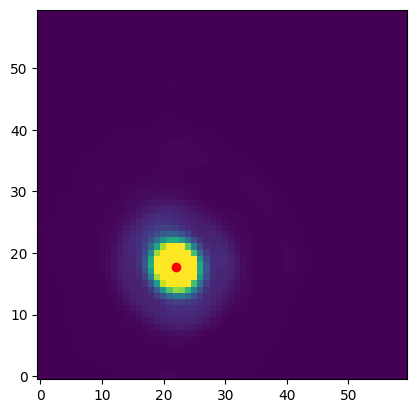

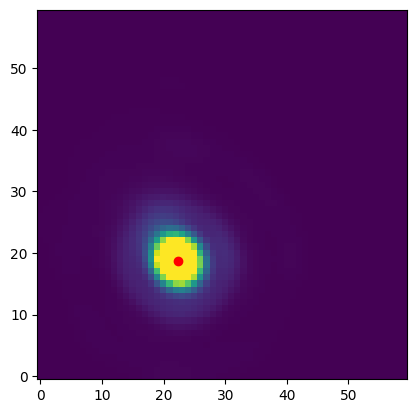

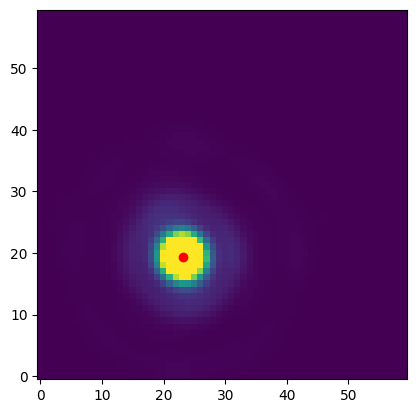

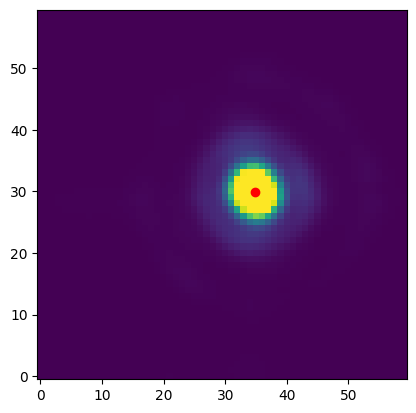

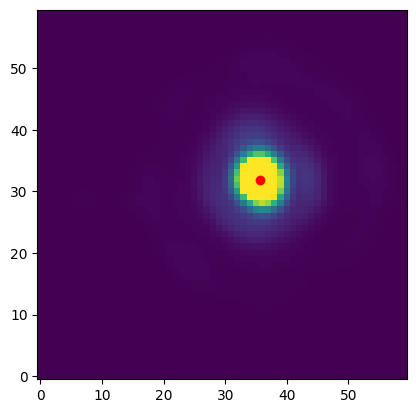

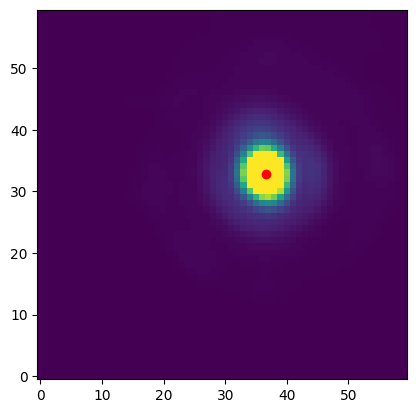

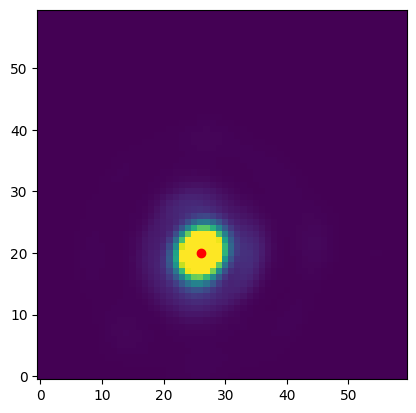

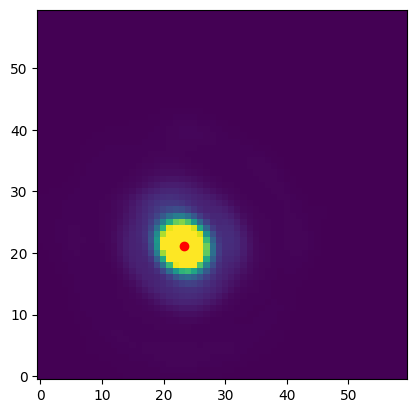

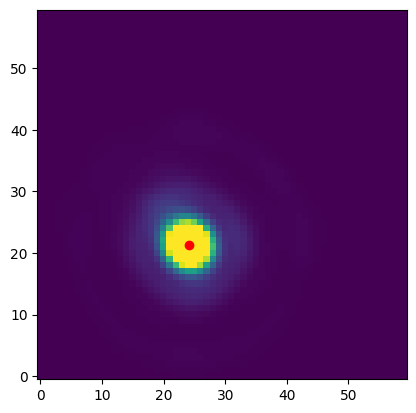

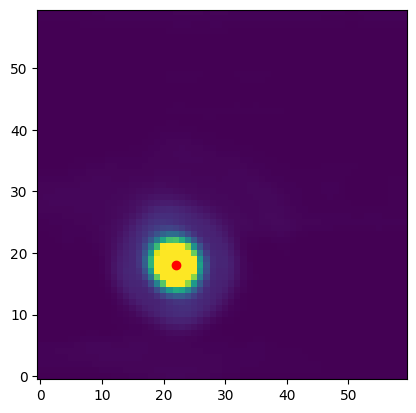

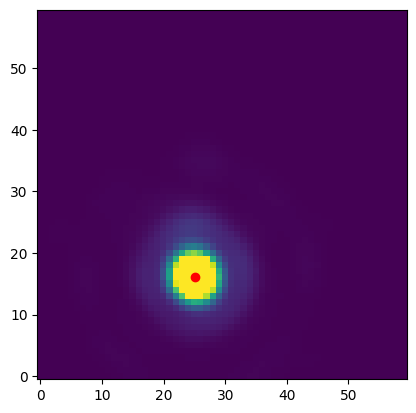

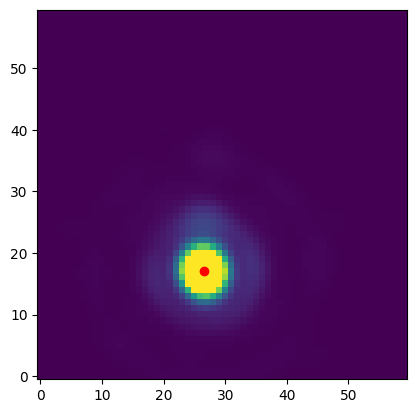

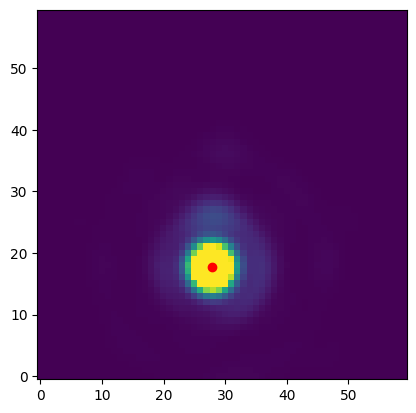

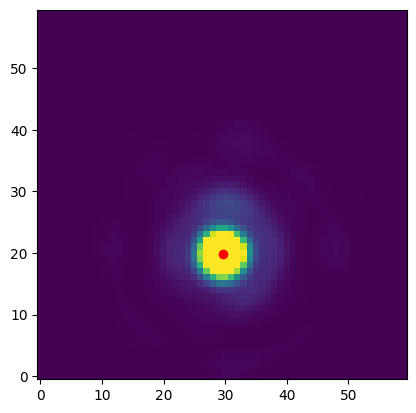

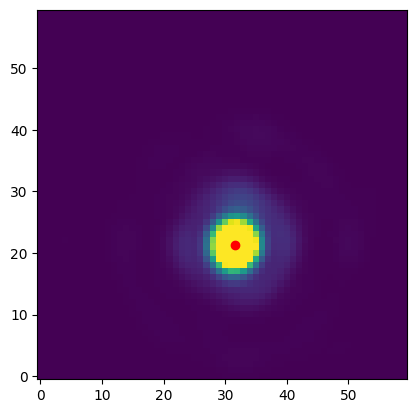

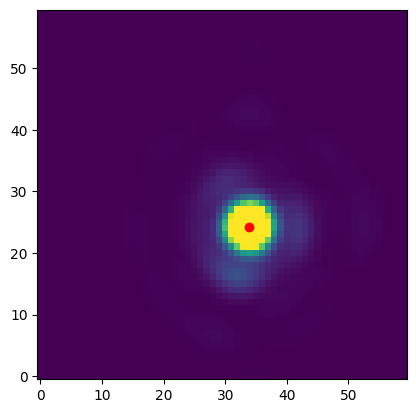

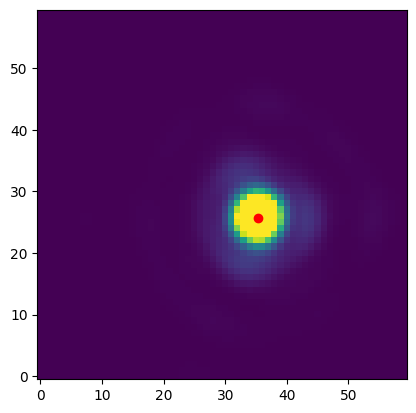

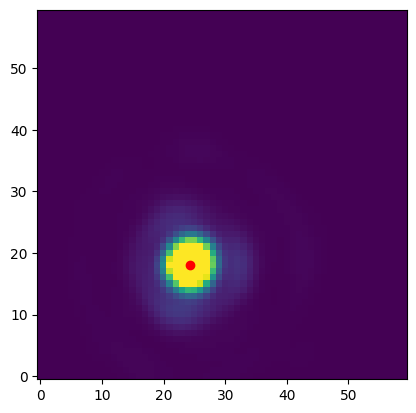

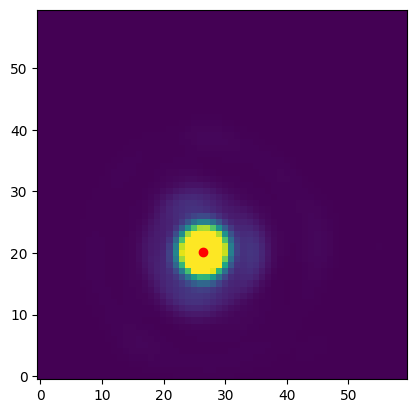

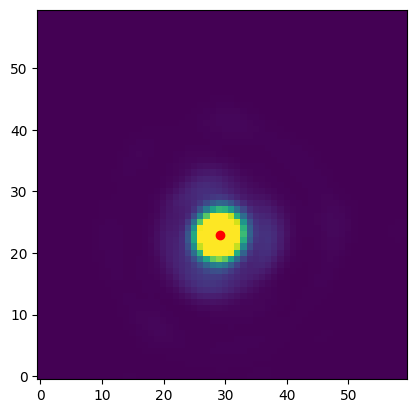

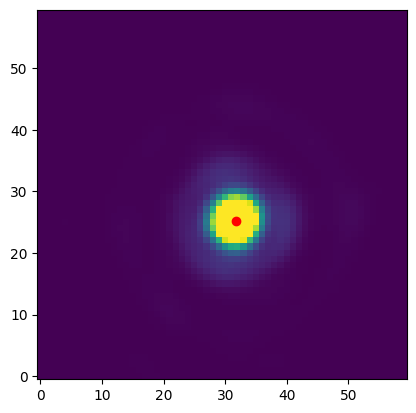

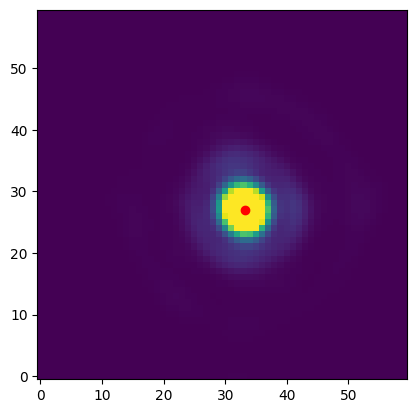

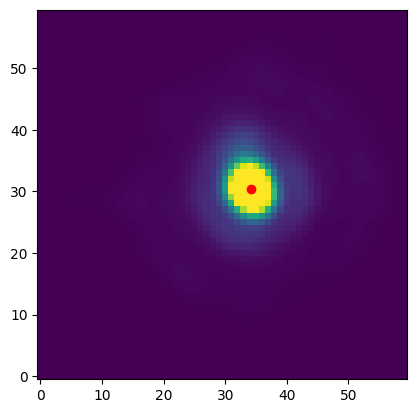

In [14]:
centroid_pointsource(pipeline,image_cube,filter_sigma=1,plot=True,save=True,save_fit_tag=which + '_cubeposition')

In [15]:
data = pipeline.get_data(which + '_cubeposition')

In [16]:
planet_position = np.array([-225.199,331.019]) # approximate position of the planet relative to the star

In [17]:
pixscale=pipeline.get_attribute('raw_'+which+'_wvlsel_nancorr_crop_outlier',attr_name='PIXSCALE')

In [18]:
planet_position_pix = np.array([-planet_position[0],planet_position[1]])/1e3/pixscale

In [25]:
lencube,lenwvl,lenx,leny=np.shape(datacube)

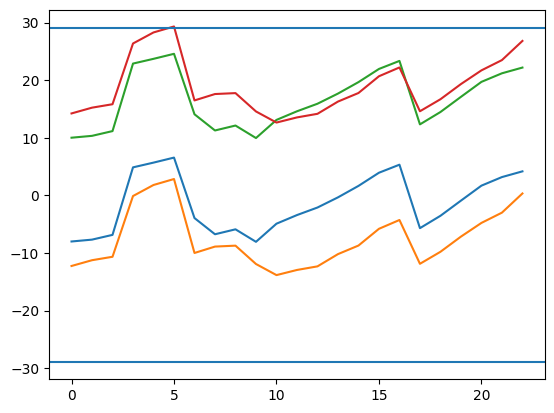

In [26]:
data = pipeline.get_data(which + '_cubeposition')
plt.plot(data[:,0])
plt.plot(data[:,2])
plt.plot(data[:,0] + planet_position_pix[0])
plt.plot(data[:,2] + planet_position_pix[1])
plt.axhline(lenx/2 - 1)
plt.axhline(-(lenx/2 - 1))

# Frame selection

In [27]:
remove_mask = np.logical_or(data[:,0] + planet_position_pix[0] > lenx/2 - 1,data[:,2] + planet_position_pix[1] > leny/2 - 1)
remove_frames = np.arange(len(data))[remove_mask]
remove_frames_inds = np.array([np.arange(lenwvl*i,lenwvl*(i+1)) for i in remove_frames]).flatten()

In [28]:
module = pp.RemoveFramesModule(
    name_in='remove_outofFOV', 
    image_in_tag='raw_'+ which + '_wvlsel_nancorr_crop_outlier', 
    selected_out_tag='raw_'+ which + '_wvlsel_nancorr_crop_outlier_sel', 
    removed_out_tag = 'None', 
    frames = remove_frames_inds)
pipeline.add_module(module)
pipeline.run_module('remove_outofFOV')

nframes = pipeline.get_attribute('raw_'+ which + '_wvlsel_nancorr_crop_outlier',attr_name='NFRAMES',static=False)
new_nframes = nframes[~np.isin(np.arange(len(nframes)), remove_frames)]
pipeline.set_attribute(data_tag = 'raw_'+ which + '_wvlsel_nancorr_crop_outlier_sel',attr_name='NFRAMES',attr_value = new_nframes,static=False)
files = pipeline.get_attribute('raw_'+ which + '_wvlsel_nancorr_crop_outlier',attr_name='FILES',static=False)
new_files = files[~np.isin(np.arange(len(files)), remove_frames)]
pipeline.set_attribute(data_tag = 'raw_'+ which + '_wvlsel_nancorr_crop_outlier_sel',attr_name='FILES',attr_value = new_files,static=False)


------------------
RemoveFramesModule
------------------

Module name: remove_outofFOV
Input port: raw_planet_wvlsel_nancorr_crop_outlier (44252, 60, 60)
Writing selected data... 23.3% - ETA: 00:00:11

/home/ipa/quanz/user_accounts/jhayoz/Projects/PynPoint-IFS/ENV_IFS_DEV/lib/python3.11/site-packages/pynpoint/core/dataio.py:943: UserWarning: The dataset that is appended under the tag name 'raw_planet_wvlsel_nancorr_crop_outlier_sel' is empty.
  warnings.warn(f'The dataset that is appended under the tag name \'{tag}\' '
/home/ipa/quanz/user_accounts/jhayoz/Projects/PynPoint-IFS/ENV_IFS_DEV/lib/python3.11/site-packages/pynpoint/core/dataio.py:943: UserWarning: The dataset that is appended under the tag name 'raw_planet_wvlsel_nancorr_crop_outlier_sel' is empty.
  warnings.warn(f'The dataset that is appended under the tag name \'{tag}\' '


Writing selected data... [DONE]                      
Output ports: raw_planet_wvlsel_nancorr_crop_outlier_sel (42328, 60, 60), None (1924, 60, 60)


In [29]:
datacube,wavelength = get_cubes(pipeline,'raw_'+which+'_wvlsel_nancorr_crop_outlier_sel','wavelength_'+which)

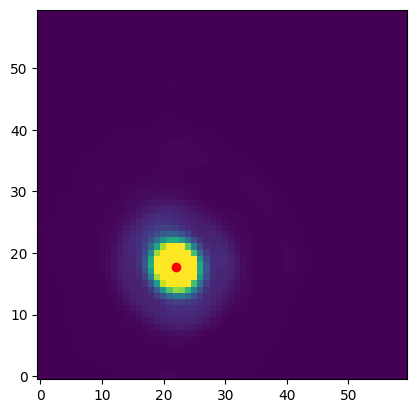

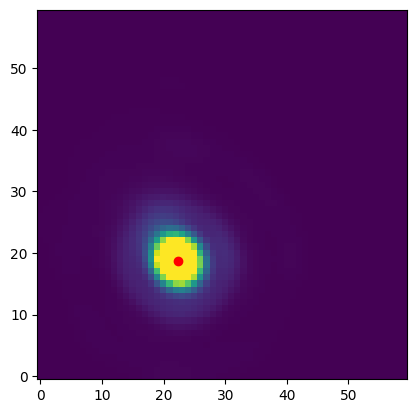

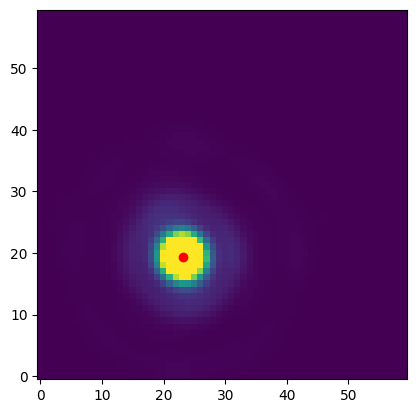

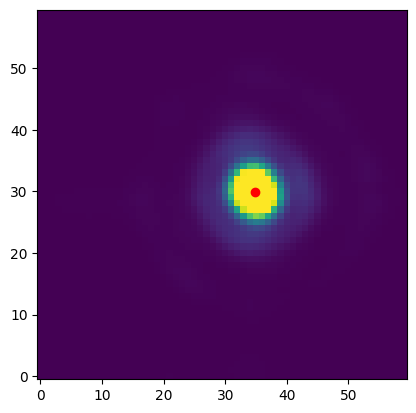

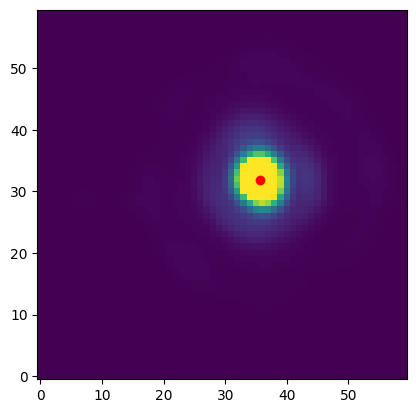

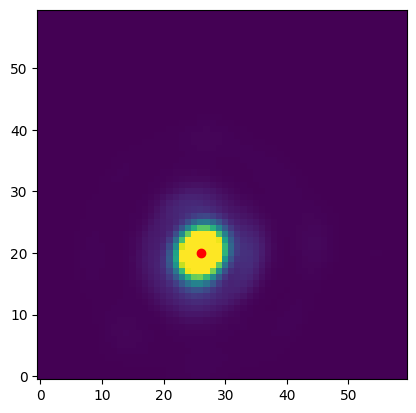

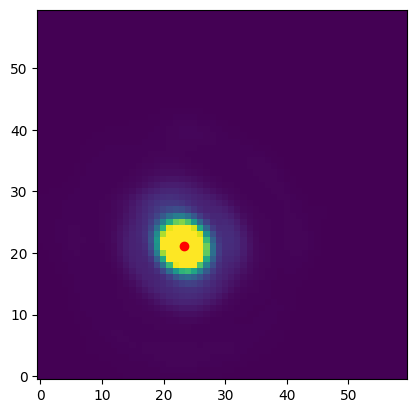

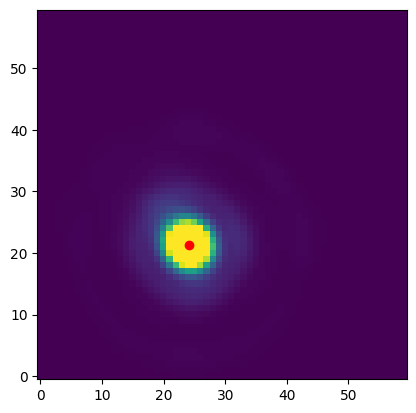

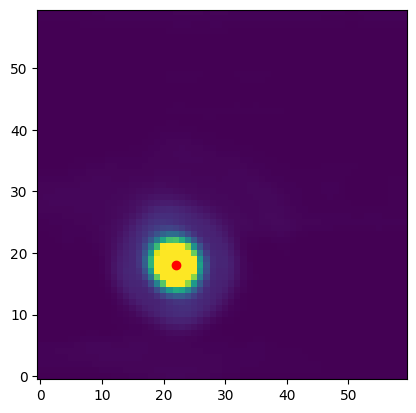

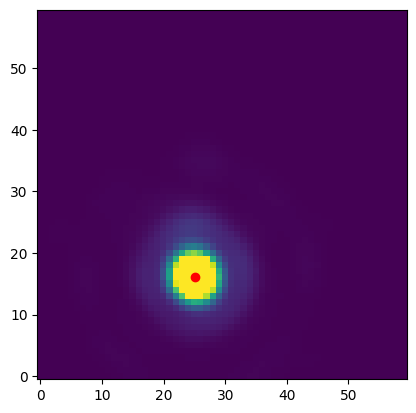

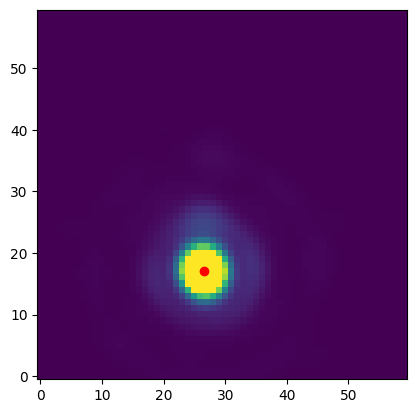

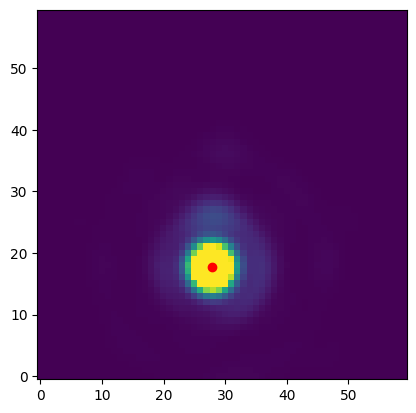

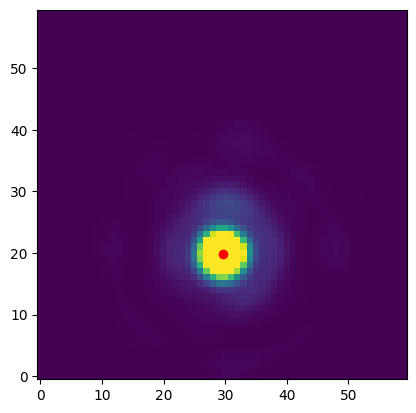

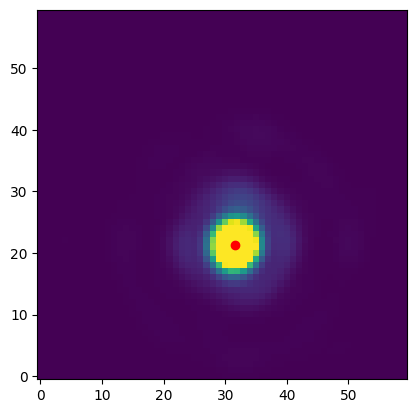

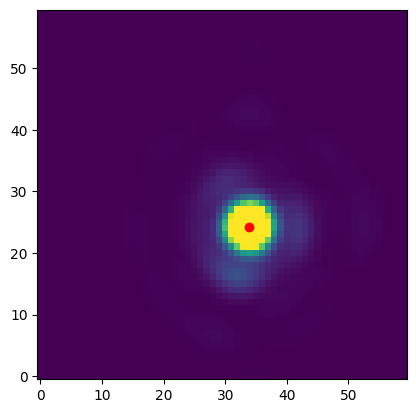

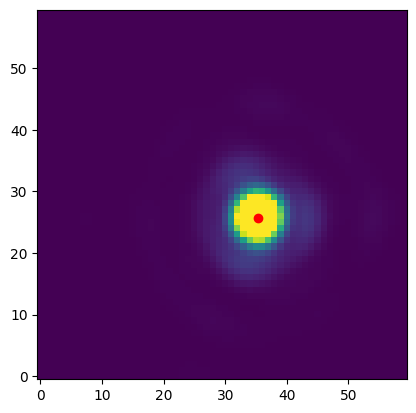

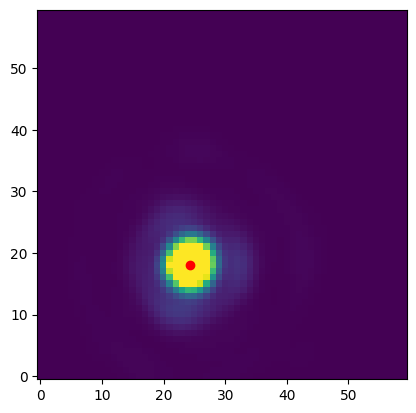

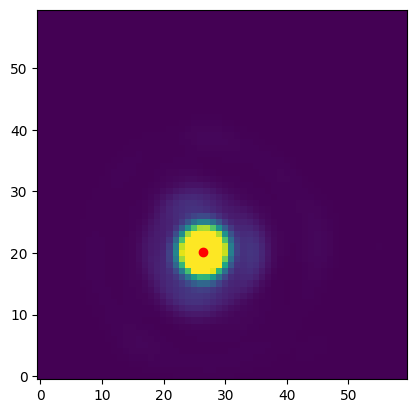

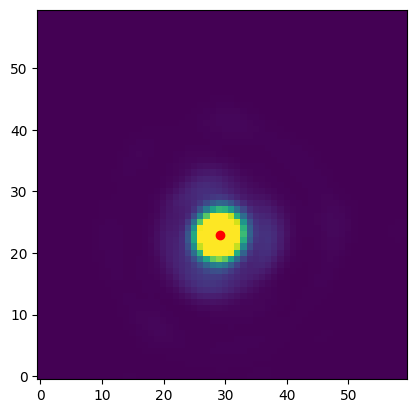

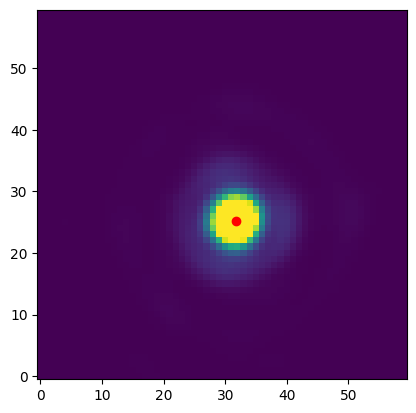

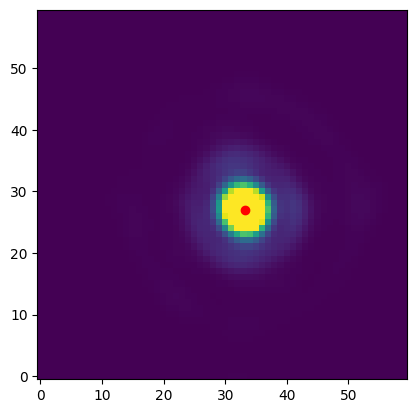

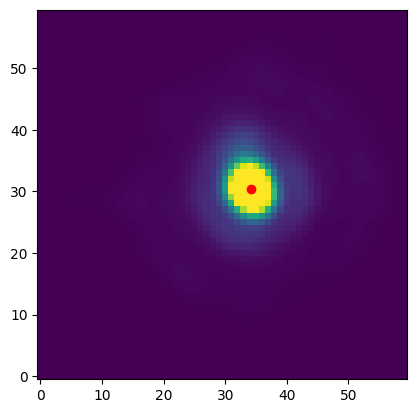

In [30]:
image_cube = np.mean(datacube,axis=1)
centroid_pointsource(pipeline,image_cube,filter_sigma=1,plot=True,save=True,save_fit_tag=which + '_sel_cubeposition')

# Test PSF subtraction with spectral PCA using different numbers of PCs

In [ ]:
pca_numbers = np.logspace(np.log10(40),np.log10(500),5,dtype=int)

In [ ]:
template_path = '/home/ipa/quanz/shared/eris/P112_atmospheres/planet_templates/grid_temperature/templates_T_1200/'
wavelength = pipeline.get_data('wavelength_' + which)
wlen_mol,flux_mol = load_custom_templates(glob(template_path + '*csv'),wavelength,sigma=20)
molecules = list(wlen_mol.keys())
rv_range,drv=300,1

In [ ]:
molecules = ['H2O','CO','CO2','CH4','chem_equ']

In [ ]:
for pca_i,pca in enumerate(pca_numbers):
    # PCA
    module = IFUPCAPSFSubtractionModule(
        name_in = f'PCA_sub_{pca}',
        image_in_tag = 'raw_'+ which + '_wvlsel_nancorr_crop_outlier',
        wv_in_tag = 'wavelength_' + which,
        image_out_tag = 'HRSDI_PCA',
        pca_number = int(pca),
        method='single'
        )
    pipeline.add_module(module)
    pipeline.run_module(f'PCA_sub_{pca}')
    # frame combining
    module = CrossCorrelationPreparationModule(
        name_in=f'combine_HRSDI_PCA_{pca}',
        image_in_tag='HRSDI_PCA',
        shift_cubes_in_tag=which + '_cubeposition_relative',
        image_out_tag='HRSDI_PCA_prep',
        mask_out_tag='mask',
        shift=True,
        rotate=False,
        stack=True)
    pipeline.add_module(module)
    pipeline.run_module(f'combine_HRSDI_PCA_{pca}')
    # cross-correlation
    for mol_i in range(len(molecules)):
        molec = molecules[mol_i]
        module = CrossCorrelationModule(
            name_in = f'combine_HRSDI_PCA_{pca}_{molec}',
            RV = rv_range,
            dRV = drv,
            range_CCF_RV = 100.,
            data_wv_in_tag = 'wavelength_' + which,
            model_wv = wlen_mol[molec],
            model_abs = flux_mol[molec],
            image_in_tag = 'HRSDI_PCA_prep',
            SNR_cube_out_tag = f'snr_{pca}_{molec}_' + which,
            CC_cube_out_tag = f'CC_{pca}_{molec}_' + which,
            RV_data_out_tag = f'RV_{pca}_{molec}_' + which,
            cpus=20
            )
        pipeline.add_module(module)
        pipeline.run_module(f'combine_HRSDI_PCA_{pca}_{molec}')

In [ ]:
rv = np.arange(-rv_range,rv_range+0.5*drv,drv)
rv_planet = 0
col_nb = len(molecules)+1
combined_cc = {}
combined_snr = {}
for pca_i,pca in enumerate(pca_numbers):
    fig,axes = plt.subplots(figsize=(3*(len(molecules)+1),5),ncols=col_nb)
    cc_mol={}
    for mol_i in range(len(molecules)):
        molec = molecules[mol_i]
        cc_mol[molec] = pipeline.get_data(f'CC_{pca}_{molec}_' + which)[0]
        # snr = snr_map(rv,cc_mol[molec],signal_range=(-20,20),std_interval = 100)
        # snr = pipeline.get_data(f'snr_{pca}_{molec}')[0]
        snr = cc_mol[molec][len(rv)//2]
        # smooth = gaussian_filter(snr,0.75)
        axes[mol_i].imshow(snr,origin='lower')
    CC_tot = np.product([cc_mol[key] for key in molecules],axis=0)
    # snr_from_CC = snr_map(rv,CC_tot,signal_range=(-20,20),std_interval = 100)
    snr_from_CC = CC_tot[len(rv)//2 + int(rv_planet/drv)]
    combined_cc[pca] = CC_tot
    combined_snr[pca] = snr_from_CC
    # smooth = gaussian_filter(snr_from_CC,0.75)
    axes[col_nb-1].imshow(snr_from_CC,origin='lower')
    for i in range(col_nb):
        if i < len(molecules):
            mol_title = molecules[i]
        else:
            mol_title = 'all'
        axes[i].set_title('PCA: %i, Mol: %s' % (pca,mol_title))
        axes[i].scatter(x=39,y=44,color='w',s=2)
        # axes[i].scatter(x=lenx/2 + mean_pos_planet[0], y= lenx/2 + mean_pos_planet[1],s=1,color='r',marker='x')
        # axes[i].scatter(x= lenx/2  + mean_pos_planet[0] - planet_pos_px[0], y= lenx/2 + mean_pos_planet[1] - planet_pos_px[1],s=50,color='orange',marker='*')
    plt.show()

# Select the nb of PCs and continue

In [31]:
pca = 250

In [32]:
module = IFUPCAPSFSubtractionModule(
    name_in = f'PCA_sub_{pca}',
    image_in_tag = 'raw_'+ which + '_wvlsel_nancorr_crop_outlier_sel',
    wv_in_tag = 'wavelength_' + which,
    image_out_tag = f'HRSDI_PCA_{pca}',
    pca_number = int(pca),
    method='single'
    )
pipeline.add_module(module)
pipeline.run_module(f'PCA_sub_{pca}')


--------------------------
IFUPCAPSFSubtractionModule
--------------------------

Module name: PCA_sub_250
Input ports: raw_planet_wvlsel_nancorr_crop_outlier_sel (42328, 60, 60), wavelength_planet (1924,)
Load all data
Done
Running IFUPCAPSFSubtractionModule... [DONE]                      
Output ports: HRSDI_PCA_250 (42328, 60, 60), PCA_model (42328, 60, 60)


In [35]:
# frame combining
module = CrossCorrelationPreparationModule(
    name_in=f'combine_HRSDI_PCA_{pca}',
    image_in_tag=f'HRSDI_PCA_{pca}',
    shift_cubes_in_tag=which + '_sel_cubeposition_relative',
    image_out_tag=f'HRSDI_PCA_{pca}_prep',
    mask_out_tag='mask',
    shift=True,
    rotate=False,
    stack=True)
pipeline.add_module(module)
pipeline.run_module(f'combine_HRSDI_PCA_{pca}')


---------------------------------
CrossCorrelationPreparationModule
---------------------------------

Module name: combine_HRSDI_PCA_250
Input ports: HRSDI_PCA_250 (42328, 60, 60), planet_sel_cubeposition_relative (22, 14)


/home/ipa/quanz/user_accounts/jhayoz/Projects/PynPoint-IFS/ENV_IFS_DEV/lib/python3.11/site-packages/pynpoint/core/pypeline.py:339: UserWarning: Names of pipeline modules that are added to the Pypeline need to be unique. The current pipeline module, 'combine_HRSDI_PCA_250', does already exist in the Pypeline dictionary so the previous module with the same name will be overwritten.
  warnings.warn(f'Names of pipeline modules that are added to the Pypeline need to '


Running CrossCorrelationPreparationModule... [DONE]                      
Output ports: HRSDI_PCA_250_prep (1924, 60, 60), mask (60, 60)


In [37]:
module = ApertureCombineModule(
    name_in = 'aperture_combine',
    image_in_tag = f'HRSDI_PCA_{pca}_prep',
    image_out_tag = f'HRSDI_PCA_{pca}_prep_apertures',
    aperture_radius = 1.7,
    cpus=10
)
pipeline.add_module(module)
pipeline.run_module('aperture_combine')


---------------------
ApertureCombineModule
---------------------

Module name: aperture_combine
Input port: HRSDI_PCA_250_prep (1924, 60, 60)
Running ApertureCombineModule in parallel...


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    5.3s
[Parallel(n_jobs=10)]: Done 318 tasks      | elapsed:    7.9s
[Parallel(n_jobs=10)]: Done 1130 tasks      | elapsed:   14.6s
[Parallel(n_jobs=10)]: Done 1924 out of 1924 | elapsed:   21.1s finished


Output port: HRSDI_PCA_250_prep_apertures (1924, 60, 60)


In [38]:
template_path = '/home/ipa/quanz/shared/eris/P112_atmospheres/planet_templates/grid_temperature/templates_T_1200/'
wavelength = pipeline.get_data('wavelength_' + which)
wlen_mol,flux_mol = load_custom_templates(glob(template_path + '*csv'),wavelength,sigma=20)
molecules = list(wlen_mol.keys())
rv_range,drv=300,1

In [39]:
molecules = list(wlen_mol.keys())

In [40]:
# cross-correlation
for mol_i in range(len(molecules)):
    molec = molecules[mol_i]
    module = CrossCorrelationModule(
        name_in = f'combine_HRSDI_PCA_apertures_{pca}_{molec}',
        RV = rv_range,
        dRV = drv,
        range_CCF_RV = 100.,
        data_wv_in_tag = 'wavelength_' + which,
        model_wv = wlen_mol[molec],
        model_abs = flux_mol[molec],
        image_in_tag = f'HRSDI_PCA_{pca}_prep_apertures',
        SNR_cube_out_tag = f'snr_apertures_{pca}_{molec}',
        CC_cube_out_tag = f'CC_apertures_{pca}_{molec}',
        RV_data_out_tag = f'RV_apertures_{pca}_{molec}',
        cpus=20
        )
    pipeline.add_module(module)
    pipeline.run_module(f'combine_HRSDI_PCA_apertures_{pca}_{molec}')


---------------------------
CrossCorrelationModule_Jean
---------------------------

Module name: combine_HRSDI_PCA_apertures_250_H2O
Input ports: wavelength_planet (1924,), HRSDI_PCA_250_prep_apertures (1924, 60, 60)
Running CrossCorrelationModule...
Total iteration: 3600


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   1 tasks      | elapsed:    3.7s
[Parallel(n_jobs=20)]: Done 124 tasks      | elapsed:    4.4s
[Parallel(n_jobs=20)]: Done 530 tasks      | elapsed:    5.9s
[Parallel(n_jobs=20)]: Done 1096 tasks      | elapsed:    7.9s
[Parallel(n_jobs=20)]: Done 1826 tasks      | elapsed:   10.5s
[Parallel(n_jobs=20)]: Done 2716 tasks      | elapsed:   13.6s
[Parallel(n_jobs=20)]: Done 3600 out of 3600 | elapsed:   16.7s finished


FINISHED!
Output ports: snr_apertures_250_H2O (1, 60, 60), CC_apertures_250_H2O (1, 601, 60, 60), RV_apertures_250_H2O (601,)

---------------------------
CrossCorrelationModule_Jean
---------------------------

Module name: combine_HRSDI_PCA_apertures_250_CO
Input ports: wavelength_planet (1924,), HRSDI_PCA_250_prep_apertures (1924, 60, 60)
Running CrossCorrelationModule...
Total iteration: 3600


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 204 tasks      | elapsed:    0.8s
[Parallel(n_jobs=20)]: Done 610 tasks      | elapsed:    2.3s
[Parallel(n_jobs=20)]: Done 1176 tasks      | elapsed:    4.3s
[Parallel(n_jobs=20)]: Done 1906 tasks      | elapsed:    6.8s
[Parallel(n_jobs=20)]: Done 2796 tasks      | elapsed:   10.0s
[Parallel(n_jobs=20)]: Done 3600 out of 3600 | elapsed:   12.8s finished


FINISHED!
Output ports: snr_apertures_250_CO (1, 60, 60), CC_apertures_250_CO (1, 601, 60, 60), RV_apertures_250_CO (601,)

---------------------------
CrossCorrelationModule_Jean
---------------------------

Module name: combine_HRSDI_PCA_apertures_250_CO36
Input ports: wavelength_planet (1924,), HRSDI_PCA_250_prep_apertures (1924, 60, 60)
Running CrossCorrelationModule...
Total iteration: 3600


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 204 tasks      | elapsed:    0.9s
[Parallel(n_jobs=20)]: Done 610 tasks      | elapsed:    2.3s
[Parallel(n_jobs=20)]: Done 1176 tasks      | elapsed:    4.3s
[Parallel(n_jobs=20)]: Done 1906 tasks      | elapsed:    6.8s
[Parallel(n_jobs=20)]: Done 2796 tasks      | elapsed:   10.0s
[Parallel(n_jobs=20)]: Done 3600 out of 3600 | elapsed:   12.8s finished


FINISHED!
Output ports: snr_apertures_250_CO36 (1, 60, 60), CC_apertures_250_CO36 (1, 601, 60, 60), RV_apertures_250_CO36 (601,)

---------------------------
CrossCorrelationModule_Jean
---------------------------

Module name: combine_HRSDI_PCA_apertures_250_CH4
Input ports: wavelength_planet (1924,), HRSDI_PCA_250_prep_apertures (1924, 60, 60)
Running CrossCorrelationModule...
Total iteration: 3600


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 204 tasks      | elapsed:    0.8s
[Parallel(n_jobs=20)]: Done 610 tasks      | elapsed:    2.2s
[Parallel(n_jobs=20)]: Done 1176 tasks      | elapsed:    4.2s
[Parallel(n_jobs=20)]: Done 1906 tasks      | elapsed:    6.7s
[Parallel(n_jobs=20)]: Done 2796 tasks      | elapsed:    9.8s
[Parallel(n_jobs=20)]: Done 3600 out of 3600 | elapsed:   12.6s finished


FINISHED!
Output ports: snr_apertures_250_CH4 (1, 60, 60), CC_apertures_250_CH4 (1, 601, 60, 60), RV_apertures_250_CH4 (601,)

---------------------------
CrossCorrelationModule_Jean
---------------------------

Module name: combine_HRSDI_PCA_apertures_250_CO2
Input ports: wavelength_planet (1924,), HRSDI_PCA_250_prep_apertures (1924, 60, 60)
Running CrossCorrelationModule...
Total iteration: 3600


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 204 tasks      | elapsed:    0.8s
[Parallel(n_jobs=20)]: Done 610 tasks      | elapsed:    2.2s
[Parallel(n_jobs=20)]: Done 1176 tasks      | elapsed:    4.3s
[Parallel(n_jobs=20)]: Done 1906 tasks      | elapsed:    6.8s
[Parallel(n_jobs=20)]: Done 2796 tasks      | elapsed:   10.0s
[Parallel(n_jobs=20)]: Done 3600 out of 3600 | elapsed:   12.8s finished


FINISHED!
Output ports: snr_apertures_250_CO2 (1, 60, 60), CC_apertures_250_CO2 (1, 601, 60, 60), RV_apertures_250_CO2 (601,)

---------------------------
CrossCorrelationModule_Jean
---------------------------

Module name: combine_HRSDI_PCA_apertures_250_H2S
Input ports: wavelength_planet (1924,), HRSDI_PCA_250_prep_apertures (1924, 60, 60)
Running CrossCorrelationModule...
Total iteration: 3600


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 204 tasks      | elapsed:    0.8s
[Parallel(n_jobs=20)]: Done 610 tasks      | elapsed:    2.3s
[Parallel(n_jobs=20)]: Done 1176 tasks      | elapsed:    4.7s
[Parallel(n_jobs=20)]: Done 1906 tasks      | elapsed:    7.3s
[Parallel(n_jobs=20)]: Done 2796 tasks      | elapsed:   10.5s
[Parallel(n_jobs=20)]: Done 3600 out of 3600 | elapsed:   13.4s finished


FINISHED!
Output ports: snr_apertures_250_H2S (1, 60, 60), CC_apertures_250_H2S (1, 601, 60, 60), RV_apertures_250_H2S (601,)

---------------------------
CrossCorrelationModule_Jean
---------------------------

Module name: combine_HRSDI_PCA_apertures_250_NH3
Input ports: wavelength_planet (1924,), HRSDI_PCA_250_prep_apertures (1924, 60, 60)
Running CrossCorrelationModule...
Total iteration: 3600


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 204 tasks      | elapsed:    0.8s
[Parallel(n_jobs=20)]: Done 610 tasks      | elapsed:    2.3s
[Parallel(n_jobs=20)]: Done 1176 tasks      | elapsed:    4.3s
[Parallel(n_jobs=20)]: Done 1906 tasks      | elapsed:    6.9s
[Parallel(n_jobs=20)]: Done 2796 tasks      | elapsed:   10.0s
[Parallel(n_jobs=20)]: Done 3600 out of 3600 | elapsed:   12.8s finished


FINISHED!
Output ports: snr_apertures_250_NH3 (1, 60, 60), CC_apertures_250_NH3 (1, 601, 60, 60), RV_apertures_250_NH3 (601,)

---------------------------
CrossCorrelationModule_Jean
---------------------------

Module name: combine_HRSDI_PCA_apertures_250_FeH
Input ports: wavelength_planet (1924,), HRSDI_PCA_250_prep_apertures (1924, 60, 60)
Running CrossCorrelationModule...
Total iteration: 3600


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 204 tasks      | elapsed:    0.8s
[Parallel(n_jobs=20)]: Done 610 tasks      | elapsed:    2.2s
[Parallel(n_jobs=20)]: Done 1176 tasks      | elapsed:    4.1s
[Parallel(n_jobs=20)]: Done 1906 tasks      | elapsed:    6.7s
[Parallel(n_jobs=20)]: Done 2796 tasks      | elapsed:    9.9s
[Parallel(n_jobs=20)]: Done 3600 out of 3600 | elapsed:   12.7s finished


FINISHED!
Output ports: snr_apertures_250_FeH (1, 60, 60), CC_apertures_250_FeH (1, 601, 60, 60), RV_apertures_250_FeH (601,)

---------------------------
CrossCorrelationModule_Jean
---------------------------

Module name: combine_HRSDI_PCA_apertures_250_HCN
Input ports: wavelength_planet (1924,), HRSDI_PCA_250_prep_apertures (1924, 60, 60)
Running CrossCorrelationModule...
Total iteration: 3600


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 204 tasks      | elapsed:    0.8s
[Parallel(n_jobs=20)]: Done 610 tasks      | elapsed:    2.3s
[Parallel(n_jobs=20)]: Done 1176 tasks      | elapsed:    4.3s
[Parallel(n_jobs=20)]: Done 1906 tasks      | elapsed:    6.9s
[Parallel(n_jobs=20)]: Done 2796 tasks      | elapsed:   10.1s
[Parallel(n_jobs=20)]: Done 3600 out of 3600 | elapsed:   12.9s finished


FINISHED!
Output ports: snr_apertures_250_HCN (1, 60, 60), CC_apertures_250_HCN (1, 601, 60, 60), RV_apertures_250_HCN (601,)

---------------------------
CrossCorrelationModule_Jean
---------------------------

Module name: combine_HRSDI_PCA_apertures_250_TiO
Input ports: wavelength_planet (1924,), HRSDI_PCA_250_prep_apertures (1924, 60, 60)
Running CrossCorrelationModule...
Total iteration: 3600


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 204 tasks      | elapsed:    0.8s
[Parallel(n_jobs=20)]: Done 610 tasks      | elapsed:    2.2s
[Parallel(n_jobs=20)]: Done 1176 tasks      | elapsed:    4.3s
[Parallel(n_jobs=20)]: Done 1906 tasks      | elapsed:    6.9s
[Parallel(n_jobs=20)]: Done 2796 tasks      | elapsed:   10.0s
[Parallel(n_jobs=20)]: Done 3600 out of 3600 | elapsed:   12.8s finished


FINISHED!
Output ports: snr_apertures_250_TiO (1, 60, 60), CC_apertures_250_TiO (1, 601, 60, 60), RV_apertures_250_TiO (601,)

---------------------------
CrossCorrelationModule_Jean
---------------------------

Module name: combine_HRSDI_PCA_apertures_250_PH3
Input ports: wavelength_planet (1924,), HRSDI_PCA_250_prep_apertures (1924, 60, 60)
Running CrossCorrelationModule...
Total iteration: 3600


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 204 tasks      | elapsed:    0.8s
[Parallel(n_jobs=20)]: Done 610 tasks      | elapsed:    2.2s
[Parallel(n_jobs=20)]: Done 1176 tasks      | elapsed:    4.2s
[Parallel(n_jobs=20)]: Done 1906 tasks      | elapsed:    6.8s
[Parallel(n_jobs=20)]: Done 2796 tasks      | elapsed:   10.0s
[Parallel(n_jobs=20)]: Done 3600 out of 3600 | elapsed:   12.8s finished


FINISHED!
Output ports: snr_apertures_250_PH3 (1, 60, 60), CC_apertures_250_PH3 (1, 601, 60, 60), RV_apertures_250_PH3 (601,)

---------------------------
CrossCorrelationModule_Jean
---------------------------

Module name: combine_HRSDI_PCA_apertures_250_K
Input ports: wavelength_planet (1924,), HRSDI_PCA_250_prep_apertures (1924, 60, 60)
Running CrossCorrelationModule...
Total iteration: 3600


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 204 tasks      | elapsed:    0.8s
[Parallel(n_jobs=20)]: Done 610 tasks      | elapsed:    2.2s
[Parallel(n_jobs=20)]: Done 1176 tasks      | elapsed:    4.2s
[Parallel(n_jobs=20)]: Done 1906 tasks      | elapsed:    6.6s
[Parallel(n_jobs=20)]: Done 2796 tasks      | elapsed:    9.5s
[Parallel(n_jobs=20)]: Done 3600 out of 3600 | elapsed:   12.1s finished


FINISHED!
Output ports: snr_apertures_250_K (1, 60, 60), CC_apertures_250_K (1, 601, 60, 60), RV_apertures_250_K (601,)

---------------------------
CrossCorrelationModule_Jean
---------------------------

Module name: combine_HRSDI_PCA_apertures_250_VO
Input ports: wavelength_planet (1924,), HRSDI_PCA_250_prep_apertures (1924, 60, 60)
Running CrossCorrelationModule...
Total iteration: 3600


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 288 tasks      | elapsed:    1.1s
[Parallel(n_jobs=20)]: Done 1100 tasks      | elapsed:    3.6s
[Parallel(n_jobs=20)]: Done 2232 tasks      | elapsed:    7.5s
[Parallel(n_jobs=20)]: Done 3600 out of 3600 | elapsed:   12.2s finished


FINISHED!
Output ports: snr_apertures_250_VO (1, 60, 60), CC_apertures_250_VO (1, 601, 60, 60), RV_apertures_250_VO (601,)

---------------------------
CrossCorrelationModule_Jean
---------------------------

Module name: combine_HRSDI_PCA_apertures_250_Na
Input ports: wavelength_planet (1924,), HRSDI_PCA_250_prep_apertures (1924, 60, 60)
Running CrossCorrelationModule...
Total iteration: 3600


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 204 tasks      | elapsed:    0.9s
[Parallel(n_jobs=20)]: Done 610 tasks      | elapsed:    2.3s
[Parallel(n_jobs=20)]: Done 1176 tasks      | elapsed:    4.7s
[Parallel(n_jobs=20)]: Done 1906 tasks      | elapsed:    7.3s
[Parallel(n_jobs=20)]: Done 2796 tasks      | elapsed:   10.5s
[Parallel(n_jobs=20)]: Done 3600 out of 3600 | elapsed:   13.4s finished


FINISHED!
Output ports: snr_apertures_250_Na (1, 60, 60), CC_apertures_250_Na (1, 601, 60, 60), RV_apertures_250_Na (601,)

---------------------------
CrossCorrelationModule_Jean
---------------------------

Module name: combine_HRSDI_PCA_apertures_250_H2O+CO
Input ports: wavelength_planet (1924,), HRSDI_PCA_250_prep_apertures (1924, 60, 60)
Running CrossCorrelationModule...
Total iteration: 3600


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 288 tasks      | elapsed:    1.2s
[Parallel(n_jobs=20)]: Done 1100 tasks      | elapsed:    3.6s
[Parallel(n_jobs=20)]: Done 2232 tasks      | elapsed:    7.1s
[Parallel(n_jobs=20)]: Done 3561 out of 3600 | elapsed:   11.1s remaining:    0.1s
[Parallel(n_jobs=20)]: Done 3600 out of 3600 | elapsed:   11.1s finished


FINISHED!
Output ports: snr_apertures_250_H2O+CO (1, 60, 60), CC_apertures_250_H2O+CO (1, 601, 60, 60), RV_apertures_250_H2O+CO (601,)

---------------------------
CrossCorrelationModule_Jean
---------------------------

Module name: combine_HRSDI_PCA_apertures_250_chem_equ
Input ports: wavelength_planet (1924,), HRSDI_PCA_250_prep_apertures (1924, 60, 60)
Running CrossCorrelationModule...
Total iteration: 3600


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 288 tasks      | elapsed:    1.1s
[Parallel(n_jobs=20)]: Done 1100 tasks      | elapsed:    3.6s
[Parallel(n_jobs=20)]: Done 2232 tasks      | elapsed:    7.2s
[Parallel(n_jobs=20)]: Done 3561 out of 3600 | elapsed:   11.2s remaining:    0.1s
[Parallel(n_jobs=20)]: Done 3600 out of 3600 | elapsed:   11.3s finished


FINISHED!
Output ports: snr_apertures_250_chem_equ (1, 60, 60), CC_apertures_250_chem_equ (1, 601, 60, 60), RV_apertures_250_chem_equ (601,)


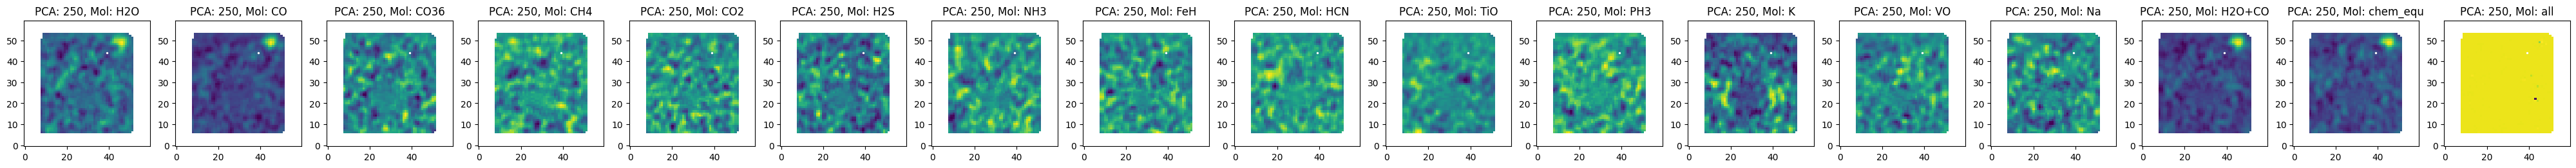

In [43]:
rv = np.arange(-rv_range,rv_range+0.5*drv,drv)
rv_planet = 0
col_nb = len(molecules)+1
fig,axes = plt.subplots(figsize=(3*(len(molecules)+1),5),ncols=col_nb)
cc_mol={}
for mol_i in range(len(molecules)):
    molec = molecules[mol_i]
    cc_mol[molec] = pipeline.get_data(f'CC_apertures_{pca}_{molec}')[0]
    # snr = snr_map(rv,cc_mol[molec],signal_range=(-20,20),std_interval = 100)
    # snr = pipeline.get_data(f'snr_{pca}_{molec}')[0]
    snr = cc_mol[molec][len(rv)//2]
    # smooth = gaussian_filter(snr,0.75)
    axes[mol_i].imshow(snr,origin='lower')
CC_tot = np.product([cc_mol[key] for key in molecules],axis=0)
# snr_from_CC = snr_map(rv,CC_tot,signal_range=(-20,20),std_interval = 100)
snr_from_CC = CC_tot[len(rv)//2 + int(rv_planet/drv)]
combined_cc = {}
combined_snr = {}
combined_cc[pca] = CC_tot
combined_snr[pca] = snr_from_CC
# smooth = gaussian_filter(snr_from_CC,0.75)
axes[col_nb-1].imshow(snr_from_CC,origin='lower')
for i in range(col_nb):
    if i < len(molecules):
        mol_title = molecules[i]
    else:
        mol_title = 'all'
    axes[i].set_title('PCA: %i, Mol: %s' % (pca,mol_title))
    axes[i].scatter(x=39,y=44,color='w',s=2)
    # axes[i].scatter(x=lenx/2 + mean_pos_planet[0], y= lenx/2 + mean_pos_planet[1],s=1,color='r',marker='x')
    # axes[i].scatter(x= lenx/2  + mean_pos_planet[0] - planet_pos_px[0], y= lenx/2 + mean_pos_planet[1] - planet_pos_px[1],s=50,color='orange',marker='*')
plt.show()

# Fit position of planet in molecular maps

In [44]:
molecules_considered = ['H2O','CO','H2O+CO','chem_equ']

CC_apertures_250_H2O


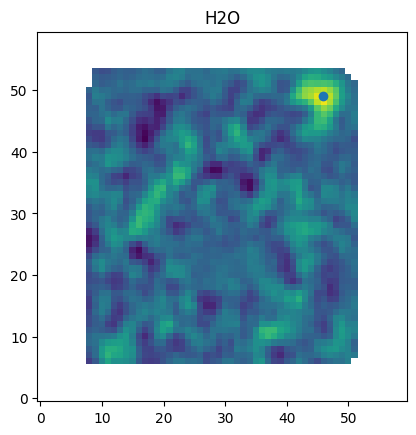

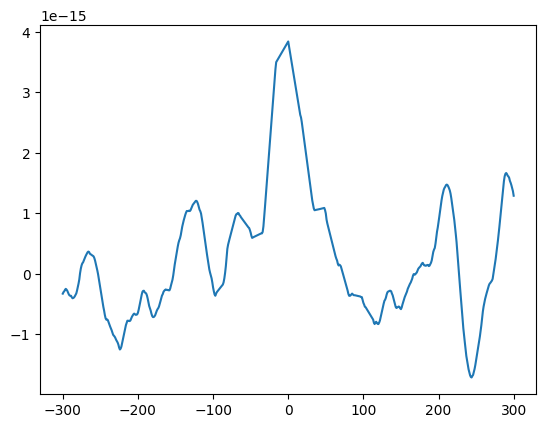

CC_apertures_250_CO


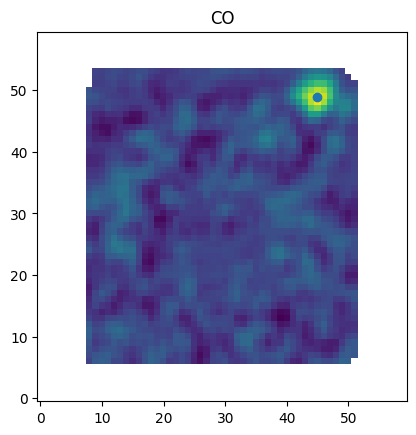

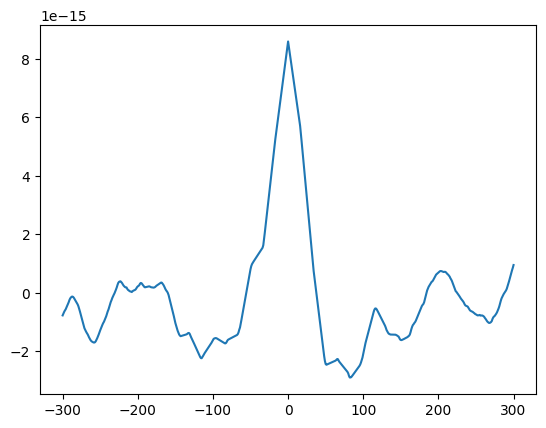

CC_apertures_250_H2O+CO


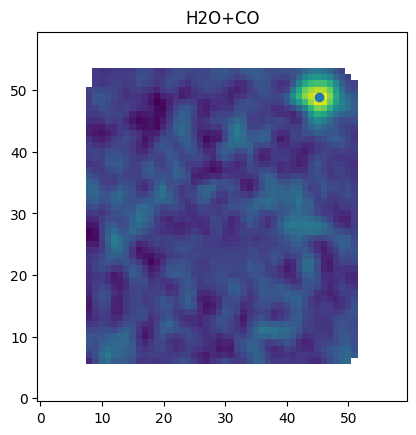

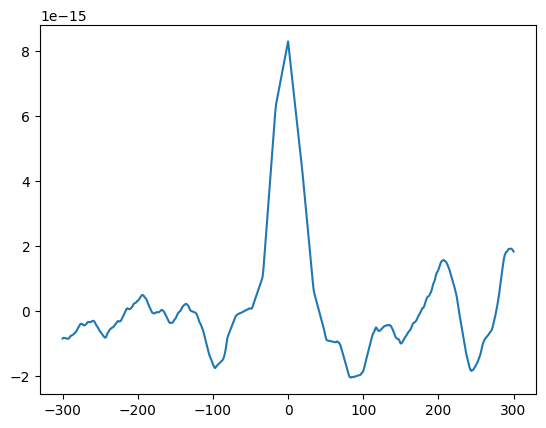

CC_apertures_250_chem_equ


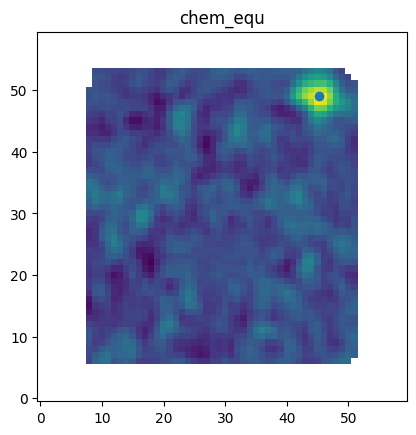

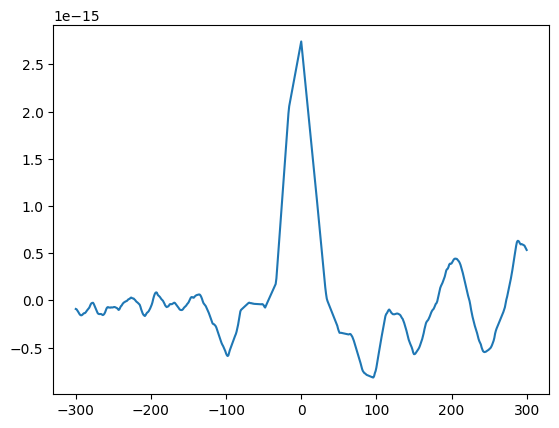

In [45]:
planet_position_mol = {}
for mol_i,mol in enumerate(molecules_considered):
    molec = molecules_considered[mol_i]
    print(f'CC_apertures_{pca}_{molec}')
    ccf = pipeline.get_data(f'CC_apertures_{pca}_{molec}')[0,:]
    snr = ccf[len(rv)//2] # snr_map(rv,ccf,signal_range=(-20,20),std_interval = 100)
    # snr = pipeline.get_data(f'snr_apertures_{pca}_{mol}')[0,crop:-crop,crop:-crop]
    # smooth = gaussian_filter(snr,0.75)
    mask = np.isnan(snr)
    image = snr
    lenx,leny=np.shape(image)
    image_f = image-np.nanmedian(image)
    
    x1, y1 = centroid_quadratic(image_f,mask=mask)
    planet_position_mol[mol] = [x1 - (lenx-1)/2,y1 - (leny-1)/2]
    
    plt.figure()
    plt.imshow(snr,origin='lower')
    plt.scatter(x=x1,y=y1)
    plt.title(mol)
    # plt.colorbar()
    plt.show()
    
    plt.figure()
    plt.plot(rv,ccf[:,int(y1),int(x1)])
    plt.show()

In [46]:
planet_position = np.mean([planet_position_mol[mol] for mol in planet_position_mol],axis=0)

In [47]:
fitparams = np.zeros((1,14))
fitparams[0,0] = planet_position[0]
fitparams[0,2] = planet_position[1]

In [48]:
out_port = pp.core.dataio.OutputPort('planet_position', data_storage_in=pipeline.m_data_storage)
out_port.set_all(fitparams)
out_port.close_port()

In [49]:
rel_pos = pipeline.get_data(which + '_sel_cubeposition_relative')

In [50]:
absolute_position_planet = fitparams + rel_pos

In [51]:
out_port = pp.core.dataio.OutputPort('planet_cubeposition_abs', data_storage_in=pipeline.m_data_storage)
out_port.set_all(absolute_position_planet)
out_port.close_port()

In [52]:
planet_position = pipeline.get_data('planet_position')[0,(0,2)]

In [53]:
rv_axis = pipeline.get_data(f'RV_apertures_{pca}_{molec}')

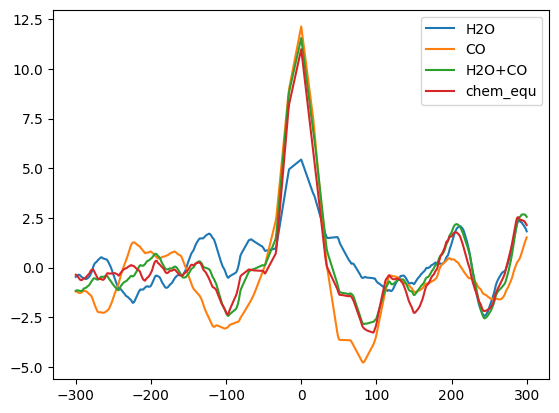

In [54]:
for mol_i,mol in enumerate(molecules_considered):
    molec = molecules_considered[mol_i]
    ccf = pipeline.get_data(f'CC_apertures_{pca}_{molec}')[0]
    lenrv,lenx,leny = np.shape(ccf)
    planet_pos_det = (planet_position + (lenx-1)/2).astype(int)
    std_ccf = np.nanstd(ccf)
    ccf_planet = ccf[:,planet_pos_det[1],planet_pos_det[0]]/std_ccf
    plt.plot(rv_axis,ccf_planet,label=molec)
plt.legend()

# Show molecular map

## PSF picture

In [55]:
datacubes,wavelength = get_cubes(pipeline,'raw_'+ which + '_wvlsel_nancorr_crop_outlier_sel','wavelength_' + which)

In [56]:
lencube,lenwvl,lenx,leny=np.shape(datacubes)

In [57]:
upscale = 3
cubeposition = pipeline.get_data(which + '_sel_cubeposition_relative')[:,(0,2)]

In [58]:
shifted_images = nice_psf_image(datacubes,upscale,cubeposition)

In [59]:
image_mean = np.nanmean(shifted_images[:],axis=0)
img_log = np.log10(image_mean)

/tmp/ipykernel_731050/1056098577.py:2: RuntimeWarning: divide by zero encountered in log10
  img_log = np.log10(image_mean)


In [60]:
add_term=0

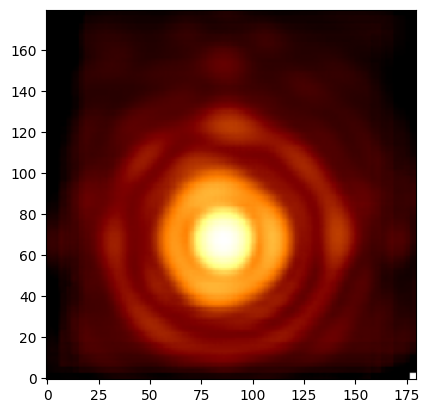

In [61]:
plt.imshow(img_log,vmin=np.percentile(img_log,5),vmax=np.percentile(img_log,99.999),cmap='afmhot',origin='lower')

## Molecular maps

In [62]:
fontsize=12
crop_x = 15
crop_y = 10

In [63]:
molecules_considered = ['H2O', 'CO', 'CH4', 'CO2', 'chem_equ','CO36','HCN','NH3','FeH','TiO','VO']
molecules_names = {mol:nice_name(mol) for mol in molecules_considered}

In [64]:
wavelength = pipeline.get_data('wavelength_' + which)
lod = np.mean(wavelength)*1e-6/8.2/np.pi*180*60*60
pixscale = pipeline.get_attribute('raw_'+ which + '_wvlsel_nancorr_crop_outlier_sel',attr_name='PIXSCALE')
lod_px = lod/pixscale

In [65]:
circle_width = lod_px
width_annulus = lod_px

In [66]:
# position of planet and star in the pictures
planet_position = pipeline.get_data('planet_position')[0,(0,2)]
fitparams_star = pipeline.get_data(which + '_sel_cubeposition')[0,(0,2)]
fitparams_star_rel = pipeline.get_data(which + '_sel_cubeposition_relative')[0,(0,2)]
star_pos_mean = fitparams_star-fitparams_star_rel

In [67]:
# rv of the detected planet
rv_planet=0

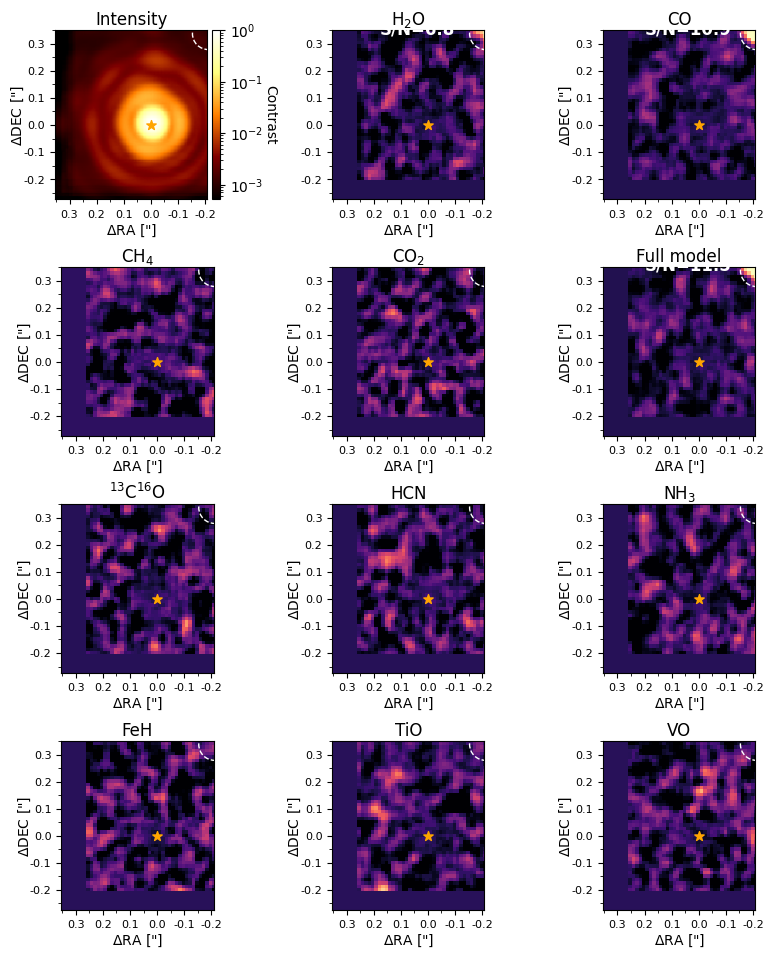

In [68]:
ncols = 3
nrows=int(np.ceil((len(molecules_considered)+1)/ncols))
fig,axes = plt.subplots(figsize=(2.5*ncols,2.2*nrows),ncols=ncols,nrows=nrows)

# PSF
image_mean = np.nanmean(shifted_images,axis=0)
star_pos = np.array([upscale*((lenx)/2  + star_pos_mean[0]), upscale*((lenx)/2 + star_pos_mean[1])])
planet_pos = np.array([upscale*((lenx-1)/2 + planet_position[0]), upscale*((lenx-1)/2 + planet_position[1])])
ticks_x_labels,tick_x_pos,ticks_x_labels_minor,tick_x_pos_minor,ticks_y_labels,tick_y_pos,ticks_y_labels_minor,tick_y_pos_minor=get_ticks(image_mean,star_pos,pixscale=pixscale/3,tick_sep=0.1,minor_tick_sep = 0.05)
tick_params = [ticks_x_labels,tick_x_pos,ticks_x_labels_minor,tick_x_pos_minor,ticks_y_labels,tick_y_pos,ticks_y_labels_minor,tick_y_pos_minor]
make_PSF_plot(ax=axes[0,0],image=image_mean,crop=0,tick_params = tick_params,fontsize=fontsize,star_pos = star_pos,title='Intensity')
plot_circle(axes[0,0],planet_pos,upscale*circle_width)
axes[0,0].set_xlim((0,len(image_mean)-crop_x*upscale))
axes[0,0].set_ylim((0,len(image_mean)-crop_y*upscale))

# molecular maps
for mol_i,mol in enumerate(molecules_considered):
    cc = pipeline.get_data(f'CC_apertures_{pca}_{mol}')[0]
    drv = pipeline.get_data(f'RV_apertures_{pca}_{mol}')
    # cc = pipeline.get_data(f'CC_{pca}_{mol}_' + which)[0]
    # drv = pipeline.get_data(f'RV_{pca}_{mol}_' + which)
    #cc = pipeline.get_data(f'CC_NOapertures_{pca}_{mol}_wb')[0]
    #drv = pipeline.get_data(f'RV_NOapertures_{pca}_{mol}_wb')
    axi = (mol_i+1) // ncols
    axj = (mol_i+1) % ncols
    star_pos = np.array([((lenx)/2  + star_pos_mean[0]), ((lenx)/2 + star_pos_mean[1])])
    planet_pos = np.array([(lenx-1)/2 + planet_position[0], (lenx-1)/2 + planet_position[1]])
    
    if mol in ['H2O','CO','H2O+CO','chem_equ']:
        snr_ttest,bins_vals,bins_pos,popt,ccf_pl_val = calculate_molmap_metric(cc,drv,planet_pos,star_pos,rv_planet,mask_width=width_annulus,n_bins=20,method='image')

    
    ticks_x_labels,tick_x_pos,ticks_x_labels_minor,tick_x_pos_minor,ticks_y_labels,tick_y_pos,ticks_y_labels_minor,tick_y_pos_minor=get_ticks(cc[0,:,:],star_pos,pixscale=pixscale,tick_sep=0.1,minor_tick_sep = 0.05)
    tick_params = [ticks_x_labels,tick_x_pos,ticks_x_labels_minor,tick_x_pos_minor,ticks_y_labels,tick_y_pos,ticks_y_labels_minor,tick_y_pos_minor]
    
    make_ccf_plot(axes[axi,axj],cc,drv,rv_planet,planet_pos,star_pos,vmin=-1,vmax=5)
    plot_circle(axes[axi,axj],planet_pos,circle_width)
    # if axj == 2:
    #     axes[axi,axj].yaxis.set_label_position("right")
    #     axes[axi,axj].yaxis.tick_right()
    make_labels(axes[axi,axj],tick_params=tick_params,img=cc[0],fontsize=fontsize,title=molecules_names[molecules_considered[mol_i]])
    if axj == 1 and axi == 0:
        axes[axi,axj].set_ylabel('')
    
    if mol in ['H2O','CO','H2O+CO','chem_equ']:
        annotate_snr(axes[axi,axj],planet_pos + np.array([-20,0]),snr_ttest,fontsize=12)
    axes[axi,axj].set_xlim((0,len(cc[0])-crop_x))
    axes[axi,axj].set_ylim((0,len(cc[0])-crop_y))

plt.tight_layout()
plt.subplots_adjust(left=0.,
                    right=1., 
                    bottom=0., 
                    top=1., 
                    wspace=0.3, 
                    hspace=0.4)
fig.savefig(save_dir + 'HR8799e_detection_molmaps.png',dpi=300,bbox_inches='tight')
plt.show()

## Plot detection metrics

In [69]:
detected_models = ['H2O','CO','chem_equ']

[45.30188643 48.97266238]
[45.30188643 48.97266238]
[45.30188643 48.97266238]


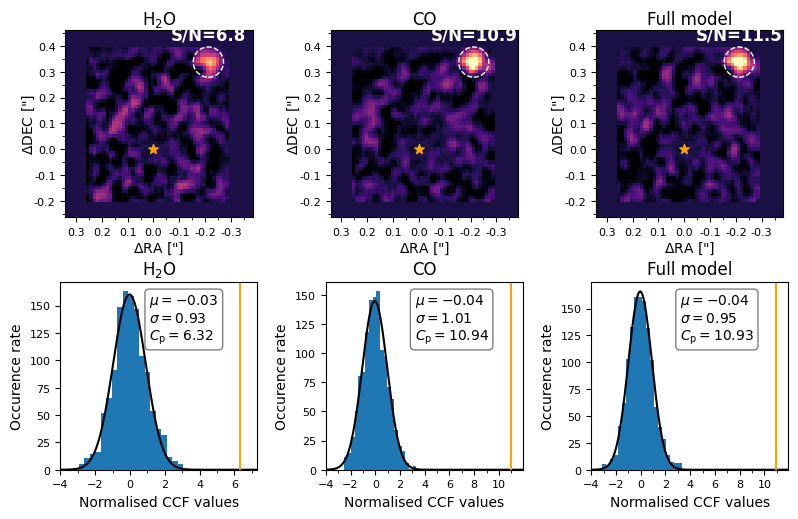

In [71]:
# plot for appendix to explain metric
crop=1
fig,axes=plt.subplots(nrows=2,ncols=len(detected_models),figsize=(2.45*len(detected_models),2.2*2))
axes= np.transpose(axes)
snr_tests_vals = {}
for mol_i,mol in enumerate(detected_models):

    cc = pipeline.get_data(f'CC_apertures_{pca}_{mol}')[0]
    drv = pipeline.get_data(f'RV_apertures_{pca}_{mol}')
    star_pos = np.array([((lenx)/2  + star_pos_mean[0]), ((lenx)/2 + star_pos_mean[1])])
    planet_pos = np.array([(lenx-1)/2 + planet_position[0], (lenx-1)/2 + planet_position[1]])
    print(planet_pos)
    dist_pl_st=np.linalg.norm(planet_pos-star_pos)
    if mol in ['H2O','CO','H2O+CO','chem_equ']:
        snr_ttest,bins_vals,bins_pos,popt,ccf_pl_val = calculate_molmap_metric(cc,drv,planet_pos,star_pos,rv_planet,mask_width=width_annulus,n_bins=20,crop=crop,method='image')
    snr_tests_vals[mol] = snr_ttest
    
    ticks_x_labels,tick_x_pos,ticks_x_labels_minor,tick_x_pos_minor,ticks_y_labels,tick_y_pos,ticks_y_labels_minor,tick_y_pos_minor=get_ticks(cc[0,:,:],star_pos,pixscale=pixscale,tick_sep=0.1,minor_tick_sep = 0.05)
    tick_params = [ticks_x_labels,tick_x_pos,ticks_x_labels_minor,tick_x_pos_minor,ticks_y_labels,tick_y_pos,ticks_y_labels_minor,tick_y_pos_minor]
    
    make_ccf_plot(axes[mol_i,0],cc,drv,rv_planet,planet_pos,star_pos,vmin=-1,vmax=6)
    plot_circle(axes[mol_i,0],planet_pos,width_annulus)
    plot_circle(axes[mol_i,0],star_pos,dist_pl_st + dist_pl_st)
    plot_circle(axes[mol_i,0],star_pos,dist_pl_st - dist_pl_st)
    make_labels(axes[mol_i,0],tick_params=tick_params,img=cc[0],fontsize=fontsize,title=molecules_names[mol])
    if mol in ['H2O','CO','H2O+CO','chem_equ']:
        annotate_snr(axes[mol_i,0],planet_pos + np.array([0,7]),snr_ttest,fontsize=fontsize)
    axes[mol_i,0].set_xlim((crop,len(cc[0])-crop))
    axes[mol_i,0].set_ylim((crop,len(cc[0])-crop))
    
    # histogram
    
    axes[mol_i,1].stairs(bins_vals,bins_pos,fill=True)
    x=np.linspace(-20,20,500)
    y = gaussian(x,popt[0],popt[1],popt[2])
    axes[mol_i,1].plot(x,y,color='k')
    axes[mol_i,1].axvline(ccf_pl_val,color='orange')

    textstr = '\n'.join((
        r'$\mu=%.2f$' % (popt[0], ),
        r'$\sigma=%.2f$' % (np.abs(popt[1]), ),
        r'$C_{\mathrm{p}}=%.2f$' % (ccf_pl_val, )))
    props = dict(boxstyle='round', facecolor='w', alpha=0.5)
    axes[mol_i,1].text(0.45, 0.95, textstr, transform=axes[mol_i,1].transAxes, fontsize=fontsize-2,
        verticalalignment='top',horizontalalignment='left', bbox=props)
    
    title_name = molecules_names[mol]
    axes[mol_i,1].set_title(title_name,fontsize=fontsize)
    ticks=np.arange(-4,(int(ccf_pl_val)//2)*2+2)
    axes[mol_i,1].set_xticks(ticks=ticks,minor=True)
    axes[mol_i,1].set_xticks(ticks=ticks[::2],minor=False)
    axes[mol_i,1].tick_params(which='both',axis='both',labelsize=fontsize-4)
    axes[mol_i,1].set_xlabel('Normalised CCF values',fontsize=fontsize-2)
    axes[mol_i,1].set_ylabel('Occurence rate',fontsize=fontsize-2)
    axes[mol_i,1].set_xlim((-4,ccf_pl_val+1))
    axes[mol_i,1].set_box_aspect(0.95)

# finish layout
plt.tight_layout()

plt.subplots_adjust(left=0.,
                    right=1., 
                    bottom=0., 
                    top=1., 
                    wspace=0.3, 
                    hspace=0.35)
fig.savefig(save_dir + 'HR8799e_detection_metric.png',dpi=300,bbox_inches='tight')
plt.show()

# Extract spectra

In [72]:
pca=250


---------------------------
IFUSpectrumExtractionModule
---------------------------

Module name: extract_spectrum_star
Input ports: raw_planet_wvlsel_nancorr_crop_outlier_sel (42328, 60, 60), planet_sel_cubeposition (22, 14)


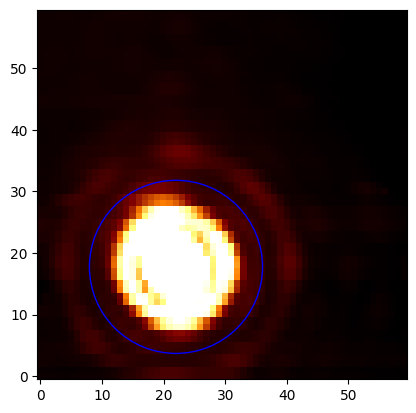

Running IFUSpectrumExtractionModule...  4.5% - ETA: 00:00:09

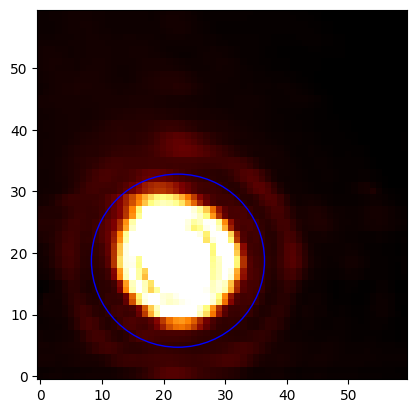

Running IFUSpectrumExtractionModule...  9.1% - ETA: 00:00:08

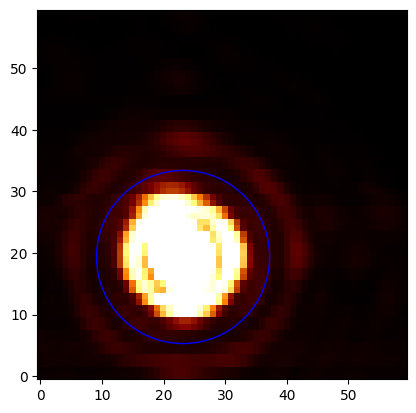

Running IFUSpectrumExtractionModule... 13.6% - ETA: 00:00:07

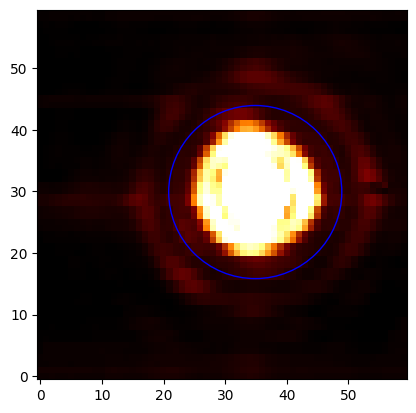

Running IFUSpectrumExtractionModule... 18.2% - ETA: 00:00:09

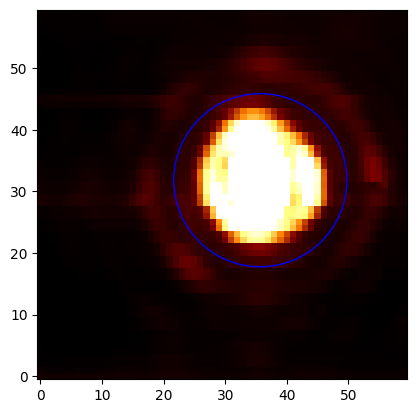

Running IFUSpectrumExtractionModule... 22.7% - ETA: 00:00:08

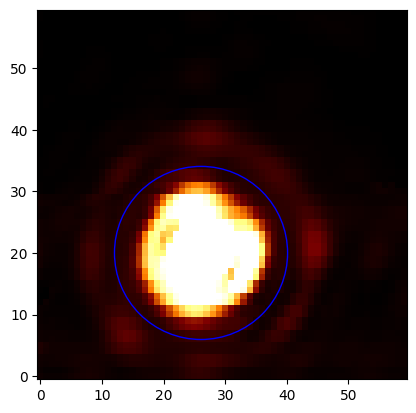

Running IFUSpectrumExtractionModule... 27.3% - ETA: 00:00:07

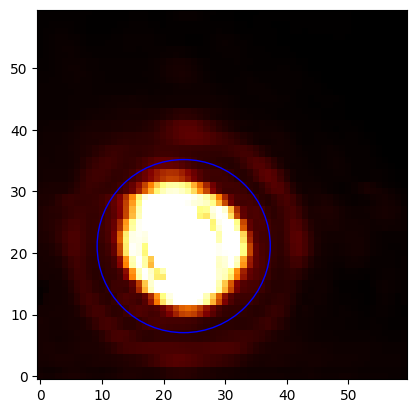

Running IFUSpectrumExtractionModule... 31.8% - ETA: 00:00:06

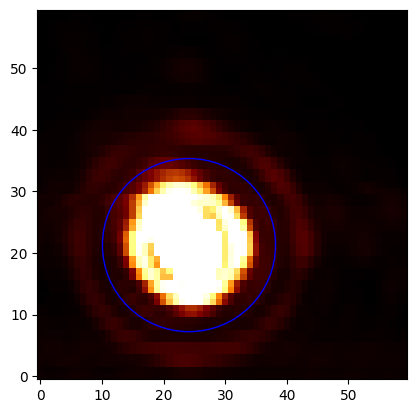

Running IFUSpectrumExtractionModule... 36.4% - ETA: 00:00:06

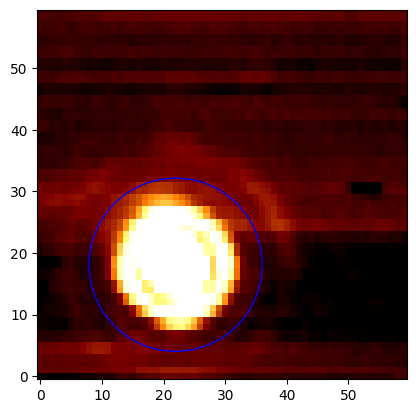

Running IFUSpectrumExtractionModule... 40.9% - ETA: 00:00:05

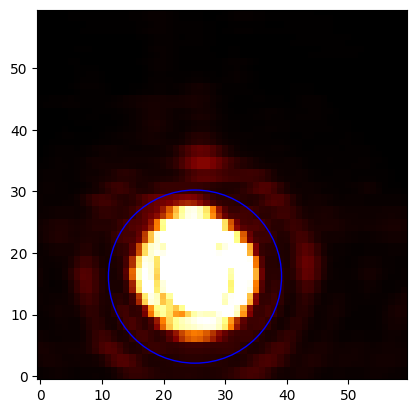

Running IFUSpectrumExtractionModule... 45.5% - ETA: 00:00:05

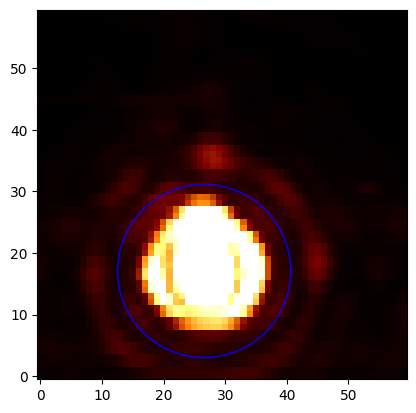

Running IFUSpectrumExtractionModule... 50.0% - ETA: 00:00:04

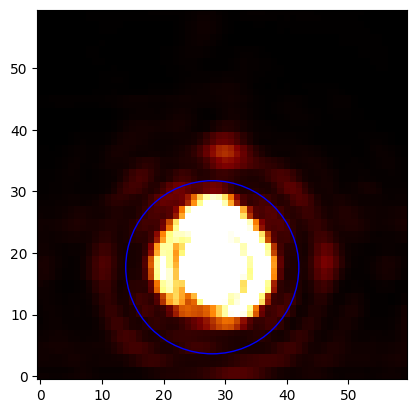

Running IFUSpectrumExtractionModule... 54.5% - ETA: 00:00:04

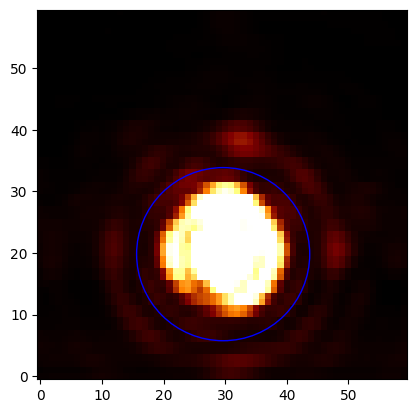

Running IFUSpectrumExtractionModule... 59.1% - ETA: 00:00:03

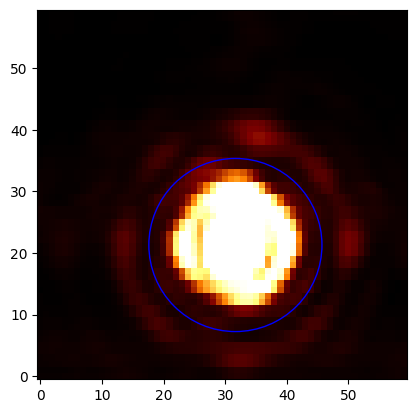

Running IFUSpectrumExtractionModule... 63.6% - ETA: 00:00:03

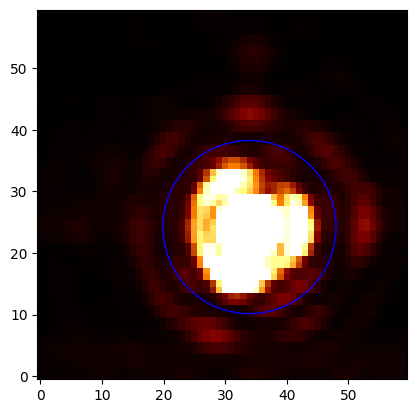

Running IFUSpectrumExtractionModule... 68.2% - ETA: 00:00:02

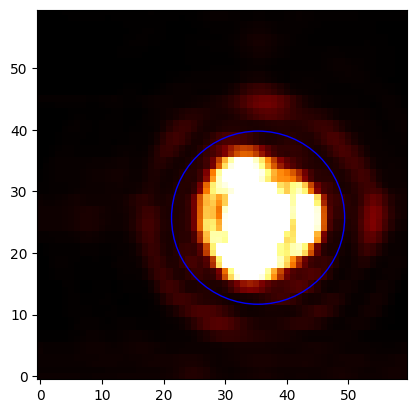

Running IFUSpectrumExtractionModule... 72.7% - ETA: 00:00:02

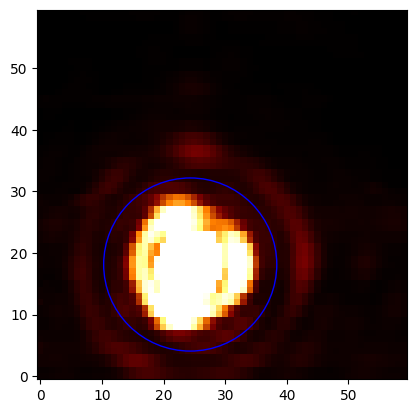

Running IFUSpectrumExtractionModule... 77.3% - ETA: 00:00:02

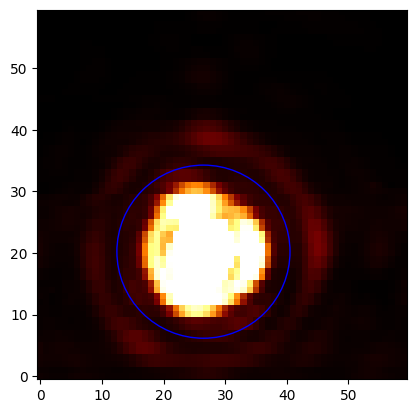

Running IFUSpectrumExtractionModule... 81.8% - ETA: 00:00:01

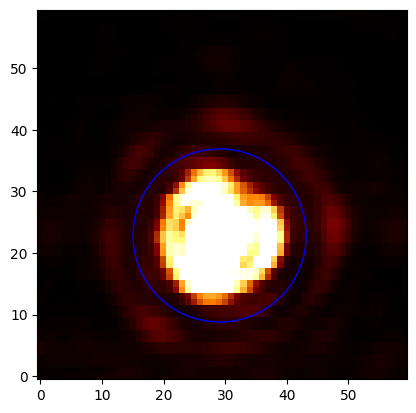

Running IFUSpectrumExtractionModule... 86.4% - ETA: 00:00:01

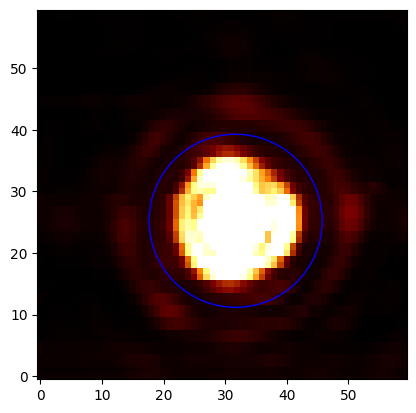

Running IFUSpectrumExtractionModule... 90.9% - ETA: 00:00:00

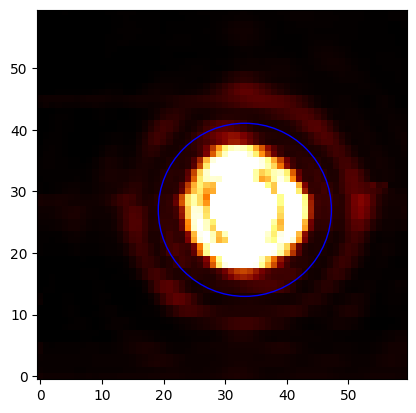

Running IFUSpectrumExtractionModule... [DONE]                      


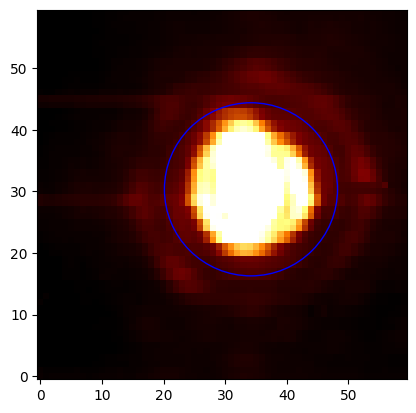

Output port: star_spectra_obj (22, 1924)


In [73]:
# get spectrum of star
module = IFUSpectrumExtractionModule(
    name_in = 'extract_spectrum_star',
    image_in_tag = 'raw_'+ which + '_wvlsel_nancorr_crop_outlier_sel',
    obj_position_in_tag = which + '_sel_cubeposition',
    obj_spectra_out_tag = 'star' + '_spectra_obj',
    bk_spectra_out_tag = 'star' + '_spectra_bk',
    aperture_obj_radius = 3*lod_px,
    aperture_bk_radius = 3,
    aperture_bk_nb = 0,
    aperture_bk_dist = 11.,
    aperture_bk_angle = 0.,
    aperture_bk_position = 'around',
    plot = True
)
pipeline.add_module(module)
pipeline.run_module('extract_spectrum_star')

In [74]:
# spectrum of planet
module = IFUSpectrumExtractionModule(
    name_in = 'extract_spectrum_planet',
    image_in_tag = f'HRSDI_PCA_{pca}',
    obj_position_in_tag = 'planet_cubeposition_abs',
    obj_spectra_out_tag = which + '_spectra_obj',
    bk_spectra_out_tag = which + '_spectra_bk',
    aperture_obj_radius = 1.7,
    aperture_bk_radius = 1.7,
    aperture_bk_nb = 10,
    aperture_bk_dist = 11.,
    aperture_bk_angle = 0.,
    aperture_bk_position = 'around',
    plot = False
)
pipeline.add_module(module)
pipeline.run_module('extract_spectrum_planet')


---------------------------
IFUSpectrumExtractionModule
---------------------------

Module name: extract_spectrum_planet
Input ports: HRSDI_PCA_250 (42328, 60, 60), planet_cubeposition_abs (22, 14)
Running IFUSpectrumExtractionModule... [DONE]                      
Output ports: planet_spectra_obj (22, 1924), planet_spectra_bk (22, 1924)



---------------------------
IFUSpectrumExtractionModule
---------------------------

Module name: extract_spectrum_planet_prep
Input ports: HRSDI_PCA_250_prep (1924, 60, 60), planet_position (1, 14)
Running IFUSpectrumExtractionModule... [DONE]                      


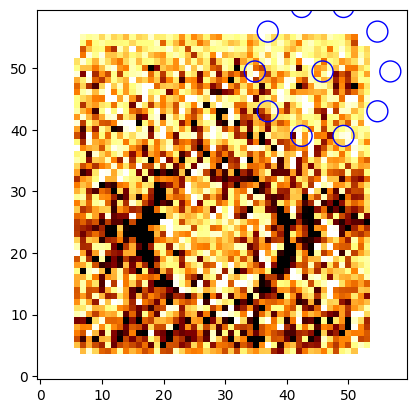

Output ports: planet_spectra_obj_prep (1, 1924), planet_spectra_bk_prep (1, 1924)


In [75]:
# spectrum of planet after combination
module = IFUSpectrumExtractionModule(
    name_in = 'extract_spectrum_planet_prep',
    image_in_tag = f'HRSDI_PCA_{pca}_prep',
    obj_position_in_tag = 'planet_position',
    obj_spectra_out_tag = which + '_spectra_obj_prep',
    bk_spectra_out_tag = which + '_spectra_bk_prep',
    aperture_obj_radius = 1.7,
    aperture_bk_radius = 1.7,
    aperture_bk_nb = 10,
    aperture_bk_dist = 11.,
    aperture_bk_angle = 0.,
    aperture_bk_position = 'around',
    plot = True
)
pipeline.add_module(module)
pipeline.run_module('extract_spectrum_planet_prep')


---------------------------
IFUSpectrumExtractionModule
---------------------------

Module name: extract_spectrum_star_planet_pos
Input ports: raw_planet_wvlsel_nancorr_crop_outlier_sel (42328, 60, 60), planet_cubeposition_abs (22, 14)


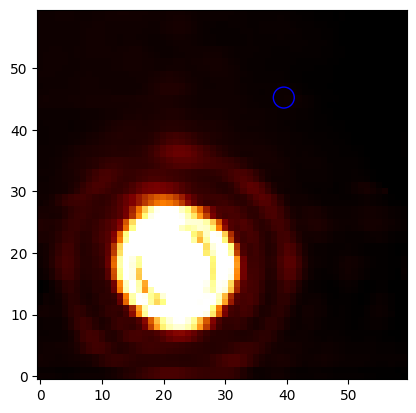

Running IFUSpectrumExtractionModule...  4.5% - ETA: 00:00:07

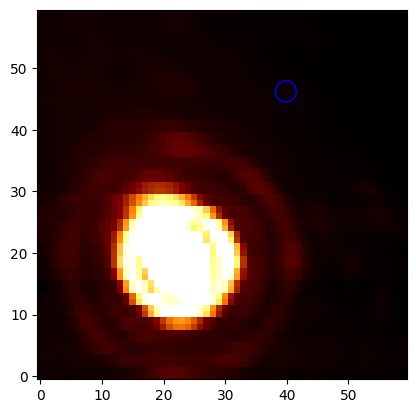

Running IFUSpectrumExtractionModule...  9.1% - ETA: 00:00:07

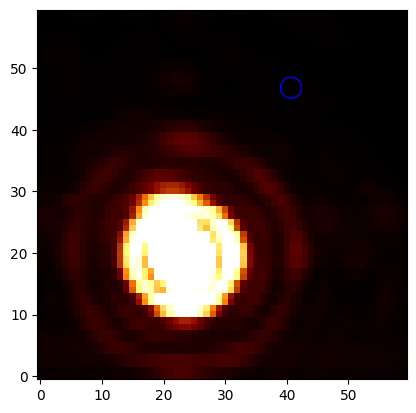

Running IFUSpectrumExtractionModule... 13.6% - ETA: 00:00:06

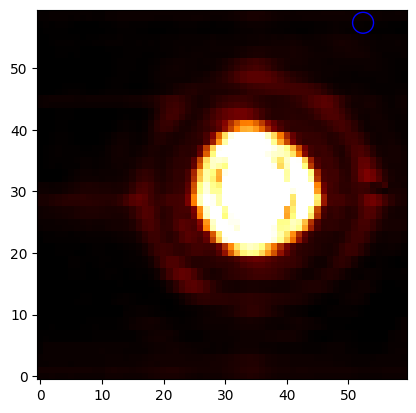

Running IFUSpectrumExtractionModule... 18.2% - ETA: 00:00:06

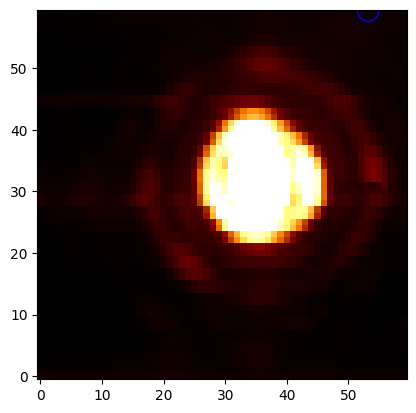

Running IFUSpectrumExtractionModule... 22.7% - ETA: 00:00:05

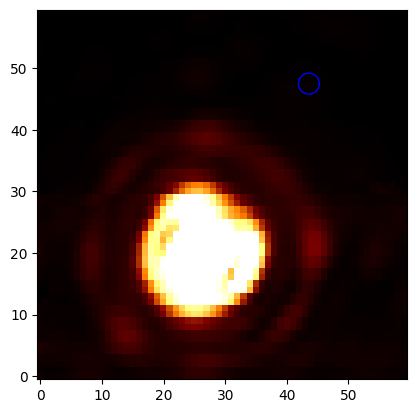

Running IFUSpectrumExtractionModule... 27.3% - ETA: 00:00:05

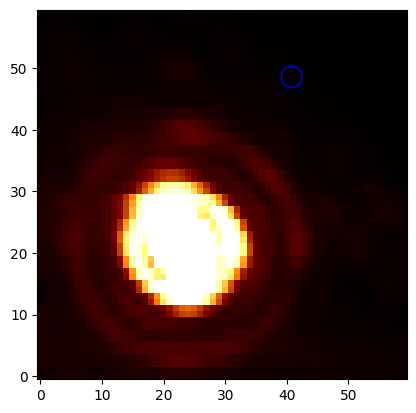

Running IFUSpectrumExtractionModule... 31.8% - ETA: 00:00:04

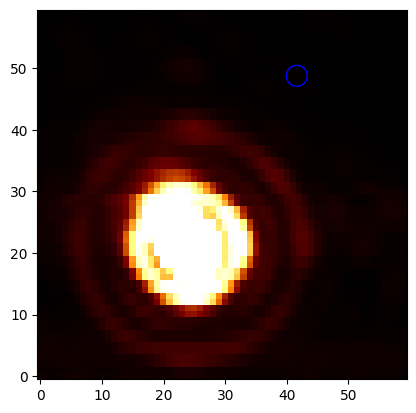

Running IFUSpectrumExtractionModule... 36.4% - ETA: 00:00:04

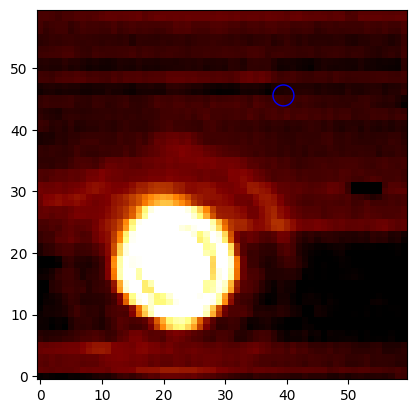

Running IFUSpectrumExtractionModule... 40.9% - ETA: 00:00:04

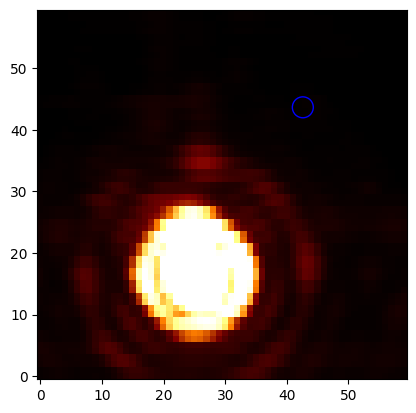

Running IFUSpectrumExtractionModule... 45.5% - ETA: 00:00:03

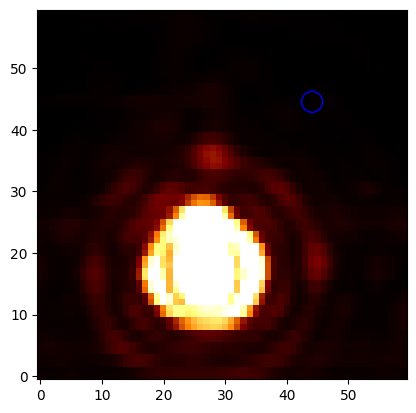

Running IFUSpectrumExtractionModule... 50.0% - ETA: 00:00:03

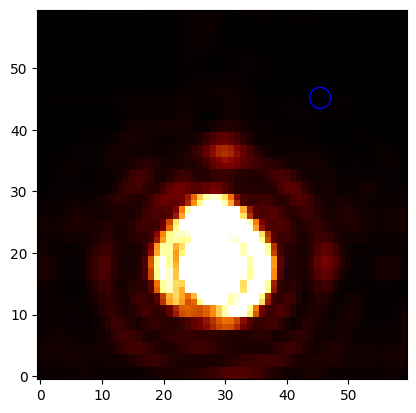

Running IFUSpectrumExtractionModule... 54.5% - ETA: 00:00:03

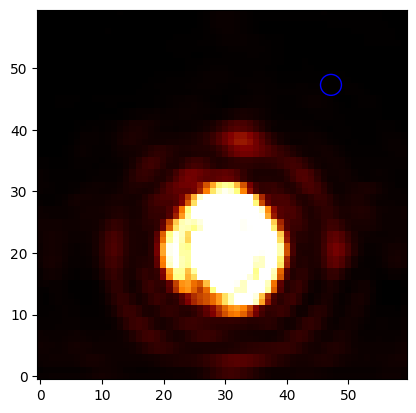

Running IFUSpectrumExtractionModule... 59.1% - ETA: 00:00:02

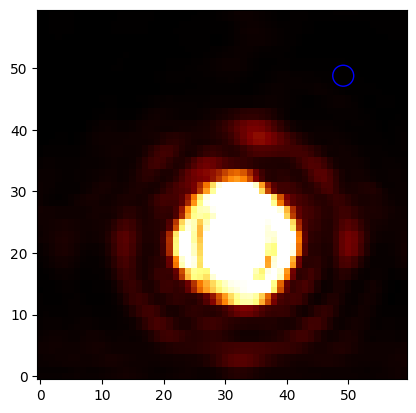

Running IFUSpectrumExtractionModule... 63.6% - ETA: 00:00:02

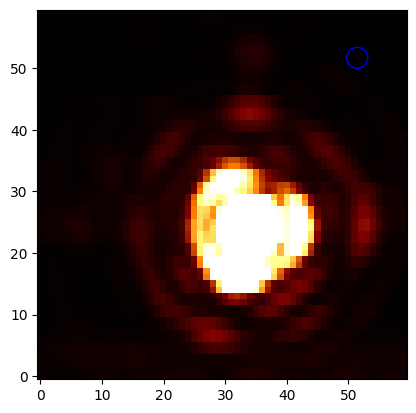

Running IFUSpectrumExtractionModule... 68.2% - ETA: 00:00:02

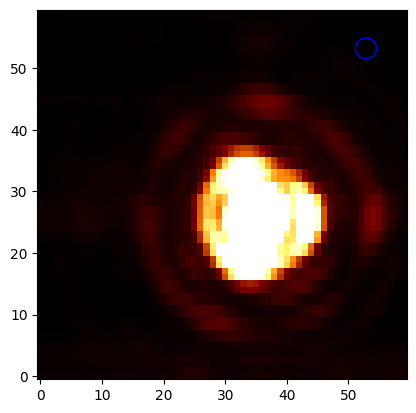

Running IFUSpectrumExtractionModule... 72.7% - ETA: 00:00:02

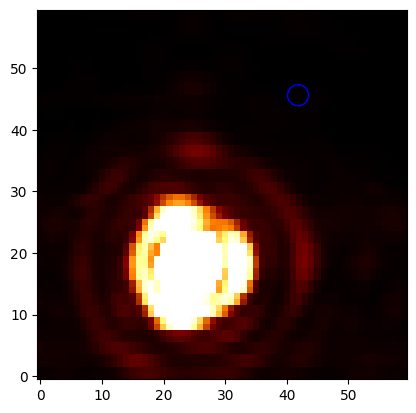

Running IFUSpectrumExtractionModule... 77.3% - ETA: 00:00:01

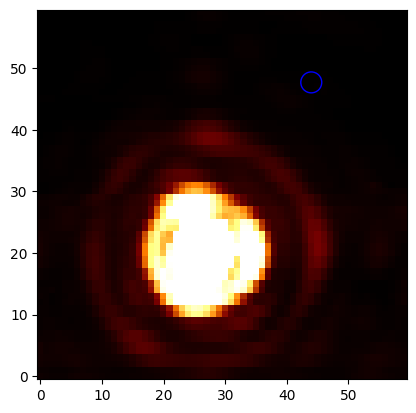

Running IFUSpectrumExtractionModule... 81.8% - ETA: 00:00:01

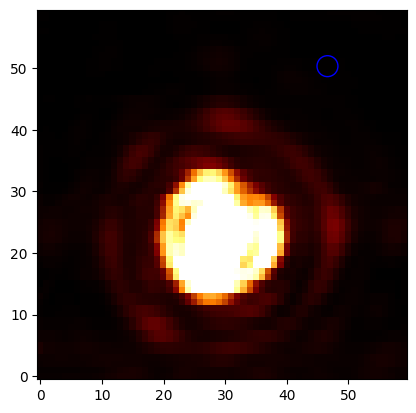

Running IFUSpectrumExtractionModule... 86.4% - ETA: 00:00:01

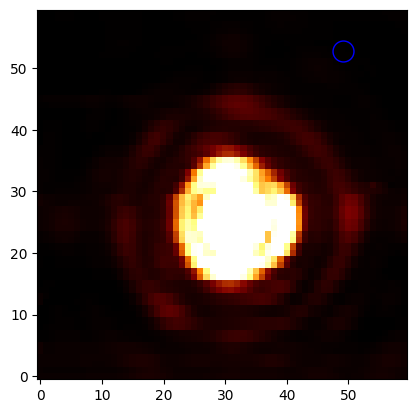

Running IFUSpectrumExtractionModule... 90.9% - ETA: 00:00:00

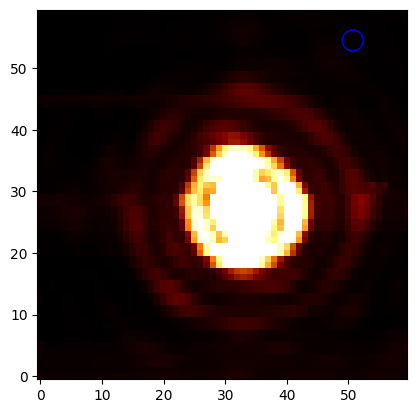

Running IFUSpectrumExtractionModule... [DONE]                      


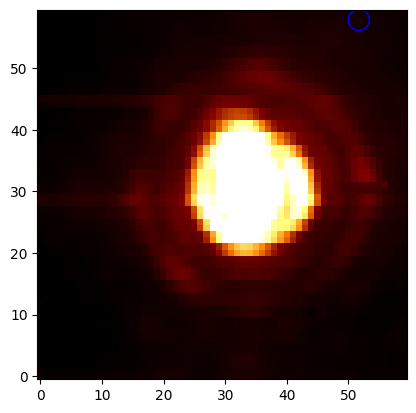

Output port: star_spectra_obj_planet_pos (22, 1924)


In [76]:
# get spectrum of star at the position of the planet
module = IFUSpectrumExtractionModule(
    name_in = 'extract_spectrum_star_planet_pos',
    image_in_tag = 'raw_'+ which + '_wvlsel_nancorr_crop_outlier_sel',
    obj_position_in_tag = 'planet_cubeposition_abs',
    obj_spectra_out_tag = 'star_spectra_obj_planet_pos',
    bk_spectra_out_tag = 'star_spectra_bk_planet_pos',
    aperture_obj_radius = 1.7,
    aperture_bk_radius = 1.7,
    aperture_bk_nb = 0,
    aperture_bk_dist = 11.,
    aperture_bk_angle = 0.,
    aperture_bk_position = 'around',
    plot = True
)
pipeline.add_module(module)
pipeline.run_module('extract_spectrum_star_planet_pos')

In [77]:
wavelength = pipeline.get_data('wavelength_' + which)
np.savetxt(save_dir + 'wavelength.txt',wavelength)

spectra_star = pipeline.get_data('star_spectra_obj')
np.savetxt(save_dir + 'spectra_star.txt',spectra_star)

spectra_planet = pipeline.get_data('planet_spectra_obj')
np.savetxt(save_dir + 'spectra_planet.txt',spectra_planet)

spectra_star = pipeline.get_data('star_spectra_obj_planet_pos')
np.savetxt(save_dir + 'spectra_star_planet_pos.txt',spectra_star)

In [80]:
# save timestamp of each frame
dateobs = pipeline.get_attribute('raw_'+ which + '_wvlsel_nancorr_crop_outlier_sel',attr_name='DATE',static=False).astype(str)
dit = pipeline.get_attribute('raw_'+ which + '_wvlsel_nancorr_crop_outlier_sel',attr_name='DIT',static=True)
delta_dit = timedelta(seconds=dit/2)
time_frame = np.array(list(map(lambda x: datetime.fromtimestamp(np.round((datetime.fromisoformat(x)-delta_dit).timestamp())).isoformat(),dateobs))).astype(str)
np.savetxt(save_dir + 'datetime.txt',time_frame,fmt='%s')